In [250]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import category_encoders as ce

from sklearn import preprocessing
from scipy.stats import shapiro

from sklearn import model_selection
from sklearn import metrics
from sklearn import tree
from sklearn import ensemble
from xgboost import XGBClassifier
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

import warnings
warnings.filterwarnings("ignore")

**LendingClub** - американская компания и крупнейшая в мире платформа по кредитованию. Компания утверждает, что по состоянию на 31 декабря 2015 года через ее платформу было выдано кредитов на сумму 15,98 миллиарда долларов. 
Цель этого проекта - спрогнозировать вероятность не возвратности кредита клиентом. То есть определить клиентов, которые не в состоянии погасить сумму кредита. Поскольку клиенты, которые не возвращают сумму своего кредита, являются источником убытков для компании, мы хотим построить модель, которая предсказывает, сможет ли конкретный заявитель погасить сумму кредита или нет. 
В процессе работы из изначального [дататсета]( https://www.kaggle.com/datasets/ethon0426/lending-club-20072020q1) я использую только данные с пометкой класса 0 - 'Fully Paid' и 1 - 'Charged Off' и заранее выбранные колонки.

``` python
data = pd.read_csv("accepted_2007_to_2018Q4.csv")
data = data[(data['loan_status'] == 'Fully Paid') | (data['loan_status'] == 'Charged Off')]
columns = ['acc_now_delinq','addr_state','annual_inc','chargeoff_within_12_mths','collections_12_mths_ex_med','delinq_2yrs','dti','earliest_cr_line','emp_length','fico_range_high','fico_range_low','funded_amnt','home_ownership','inq_last_12m','installment','int_rate','issue_d','loan_amnt','mort_acc','mths_since_last_delinq','mths_since_recent_bc_dlq','mths_since_recent_inq','num_accts_ever_120_pd','num_actv_bc_tl','num_rev_accts','num_sats','num_tl_90g_dpd_24m','num_tl_op_past_12m','open_acc','open_il_24m','open_rv_24m','percent_bc_gt_75','pub_rec','pub_rec_bankruptcies','purpose','revol_util','tax_liens','term','title','total_acc','verification_status','zip_code','loan_status']
data = data [columns]
data.to_csv('loan_status.csv')
```


Мы хотим предсказать, был ли тот или иной кредит полностью оплачен или списан (если он был выплачен или клиент не смог выплатить сумму кредита)

In [152]:
# фиксируем RANDOM_SEED для воспроизводимоcти эксперимента
RANDOM_SEED = 42

In [153]:
data1 = pd.read_csv("loan_status.csv", index_col=0)
data1.head()

,acc_now_delinq,addr_state,annual_inc,chargeoff_within_12_mths,collections_12_mths_ex_med,delinq_2yrs,dti,earliest_cr_line,emp_length,fico_range_high,...,pub_rec_bankruptcies,purpose,revol_util,tax_liens,term,title,total_acc,verification_status,zip_code,loan_status
0,0.0,AZ,24000.0,0.0,0.0,0.0,27.65,Jan-1985,10+ years,739.0,...,0.0,credit_card,83.7%,0.0,36 months,Computer,9.0,Verified,860xx,1
1,0.0,GA,30000.0,0.0,0.0,0.0,1.00,Apr-1999,< 1 year,744.0,...,0.0,car,9.4%,0.0,60 months,bike,4.0,Source Verified,309xx,0
2,0.0,IL,12252.0,0.0,0.0,0.0,8.72,Nov-2001,10+ years,739.0,...,0.0,small_business,98.5%,0.0,36 months,real estate business,10.0,Not Verified,606xx,1
3,0.0,CA,49200.0,0.0,0.0,0.0,20.00,Feb-1996,10+ years,694.0,...,0.0,other,21%,0.0,36 months,personel,37.0,Source Verified,917xx,1
4,0.0,OR,80000.0,0.0,0.0,0.0,17.94,Jan-1996,1 year,699.0,...,0.0,other,53.9%,0.0,60 months,Personal,38.0,Source Verified,972xx,1


In [154]:
#определим размер данных
data1.shape

(1860331, 43)

## Знакомство с данными

In [155]:
#посмотрим сколько столбцов разных типов присутствуют в данных
data1.dtypes.value_counts()

float64    30
object     12
int64       1
dtype: int64

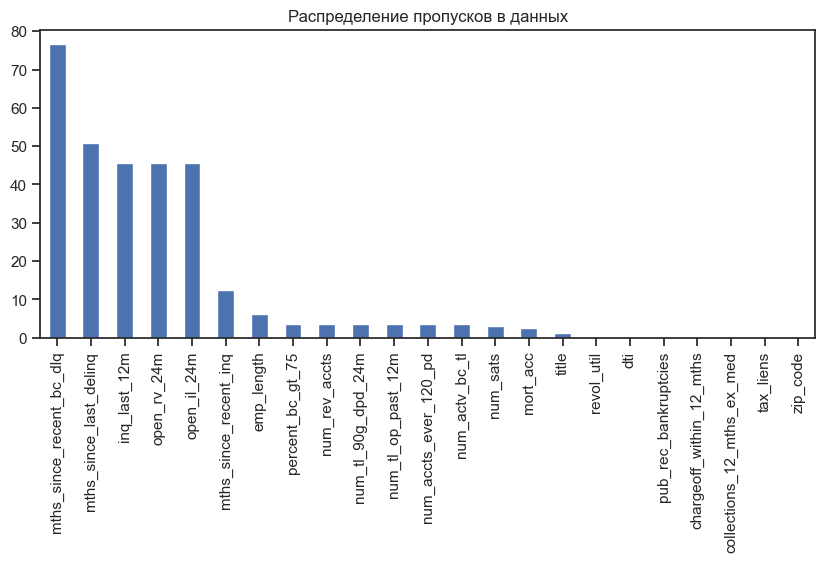

In [156]:
sns.set(style="ticks")
#посомтрим на распределение пропусков в данных
cols_null_percent = data1.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

In [157]:
#Проанализируем количественные данные и признаки типа object
data1.describe()[1:].T

,mean,std,min,25%,50%,75%,max
acc_now_delinq,0.004576,0.073115,0.00,0.00,0.00,0.00,1.400000e+01
annual_inc,77369.564789,117821.804004,0.00,46000.00,65000.00,92000.00,1.100000e+08
chargeoff_within_12_mths,0.008822,0.107913,0.00,0.00,0.00,0.00,1.000000e+01
collections_12_mths_ex_med,0.017878,0.149726,0.00,0.00,0.00,0.00,2.000000e+01
delinq_2yrs,0.312875,0.875457,0.00,0.00,0.00,0.00,4.200000e+01
dti,18.567739,13.091529,-1.00,11.82,17.71,24.29,9.990000e+02
fico_range_high,701.678642,32.709396,629.00,674.00,694.00,719.00,8.500000e+02
fico_range_low,697.678478,32.708653,625.00,670.00,690.00,715.00,8.450000e+02
funded_amnt,14582.177231,8967.822906,500.00,7925.00,12000.00,20000.00,4.000000e+04
inq_last_12m,2.185089,2.470289,0.00,0.00,2.00,3.00,6.700000e+01


In [158]:
data1.describe(include='object')[1:].T

,unique,top,freq
addr_state,51,CA,264463
earliest_cr_line,763,Sep-2003,12568
emp_length,11,10+ years,611330
home_ownership,6,MORTGAGE,918028
int_rate,684,11.99%,42791
issue_d,160,Mar-2016,57553
purpose,14,debt_consolidation,1063459
revol_util,1406,0%,10915
term,2,36 months,1393299
title,61685,Debt consolidation,941169


> **Первые выводы после первого знакомства с данными:**
1. Есть пять признаков, количество пропусков в которых превышает 40 %. Такое большое количество пропусков нет необходимости заполнять, их лучше удалить.
2. В параметрах `annual_inc`, `mort_acc` слишком большое максимальное значение. Необходимо проанализировать их на наличие выбросов.
3. В параметрах `dti`, `installment`, `funded_amnt`, `loan_amnt` слишком маленькое минимальное значение. Необходимо проанализировать их на наличие выбросов. Так же стоит сравнить между собой два параметра `funded_amnt`, `loan_amnt`, так как их статистические показатели совпадают. Возможно, у них высокая корреляция. 
4. В параметрах `num_tl_90g_dpd_24m`, `num_accts_ever_120_pd`, `pub_rec`, `pub_rec_bankruptcies`, `tax_liens`, `chargeoff_within_12_mths`, `collections_12_mths_ex_med`, delinq_2yrs более 75% строк = 0. Но так как эти признаки отвечают за различные виды просрочки и банкротств с количеством дней перевод в бинарные признаки лишит нас части данных. Необходимо проверить как сильно они влияют на целевой показатель.
5. В параметре `title` слишком много уникальных значений. 
6. Параметры `revol_util`, `emp_length`, `int_rate`, `zip_code` можно преобразовать в числовые.
7. Параметры `earliest_cr_line`, `issue_d` можно преобразовать в дату и выделить месяц и год.


In [159]:
data = data1.copy()

In [160]:
#удаляем столбцы с числом пропусков более 20% (100-80)
n = data.shape[0] #число строк в таблице
thresh = n*0.8
data = data.dropna(thresh=thresh, axis=1)
data.shape

(1860331, 38)

In [161]:
#отбрасываем строки с числом пропусков более 3 в строке
m = data.shape[1] #число признаков после удаления столбцов
data = data.dropna(thresh=m-3, axis=0)
data.shape

(1792760, 38)

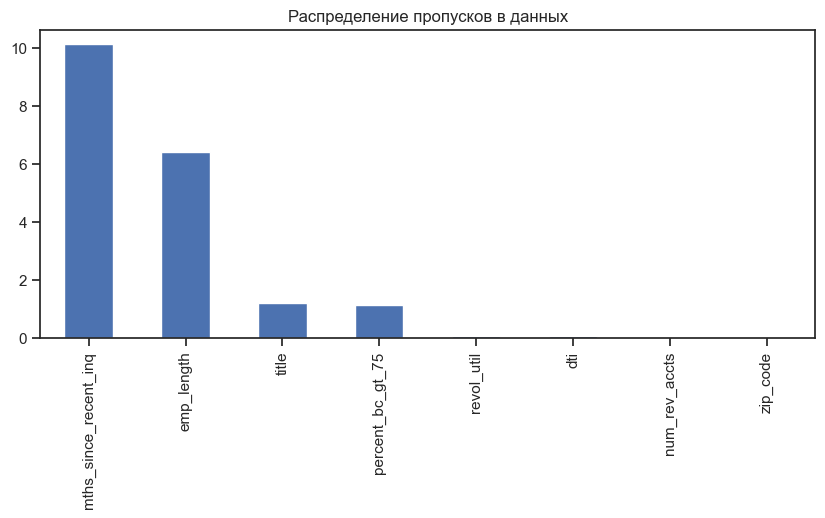

In [162]:
#посомтрим сколько пропусков в данных осталось
cols_null_percent = data.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

> Отлично. Осталось только 8 признаков с пропусками. При этом в половине из них, пропусков незначительное количество. Запомним эти признаки и обработаем пропуски, когда будем анализировать их.

In [163]:
#Проверим данные на наличие дубликатов
duplicate = data[data.duplicated()]
print(duplicate)

Empty DataFrame
Columns: [acc_now_delinq, addr_state, annual_inc, chargeoff_within_12_mths, collections_12_mths_ex_med, delinq_2yrs, dti, earliest_cr_line, emp_length, fico_range_high, fico_range_low, funded_amnt, home_ownership, installment, int_rate, issue_d, loan_amnt, mort_acc, mths_since_recent_inq, num_accts_ever_120_pd, num_actv_bc_tl, num_rev_accts, num_sats, num_tl_90g_dpd_24m, num_tl_op_past_12m, open_acc, percent_bc_gt_75, pub_rec, pub_rec_bankruptcies, purpose, revol_util, tax_liens, term, title, total_acc, verification_status, zip_code, loan_status]
Index: []

[0 rows x 38 columns]


## Разведывательный анализ, отчистка от выбросов и создание новых признаков

### Показатель loan_status - целевой показатель, вернёт ли заёмщик кредит (0) или выйдет на просрочку (1)

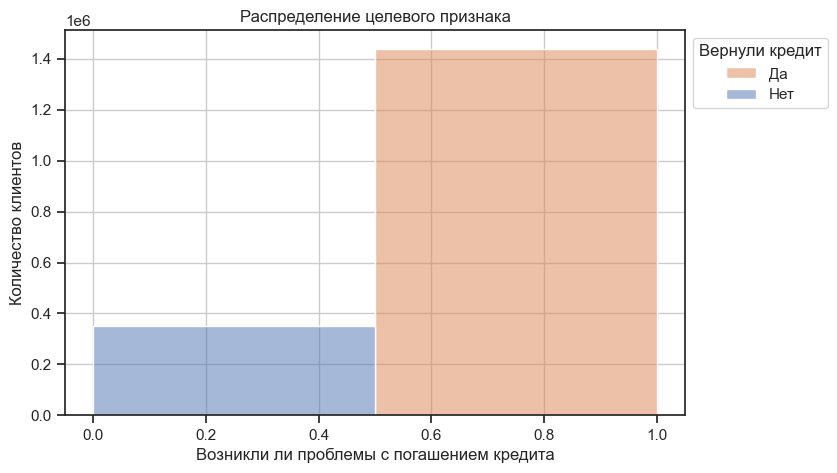

In [164]:
#Проверим распределение целевого признака на очищенных данных
fig = plt.figure(figsize=(8, 5))
histplot = sns.histplot(data, 
    x='loan_status',
    hue="loan_status",
    binwidth=0.5);

histplot.set_title('Распределение целевого признака');
histplot.set_xlabel('Возникли ли проблемы с погашением кредита');
histplot.set_ylabel('Количество клиентов');
histplot.legend( ['Да','Нет'], bbox_to_anchor=(1, 1), title='Вернули кредит');
histplot.grid()


> На полученном графике видно, что данные распределены неравномерно. Это следует учесть при разбивке данных на выборки.

### Показатель addr_state - штат проживания клиента

In [165]:
#посмотрим зависит ли от штата просрочки по кредитам
data_loc = data.groupby('addr_state')['loan_status'].count()
fig = px.choropleth(
    data_frame=data_loc, 
    locations=data_loc.index, 
    color='loan_status',
    locationmode="USA-states",
    scope="usa"
)
fig.show()

Как видно на графике больше всего просроченных кредитов в штате Калифорния, что, скорее всего, обусловлено высоким уровнем жизни в этом штате. За ним следуют штаты Техас, Нью-Йорк и Флорида.

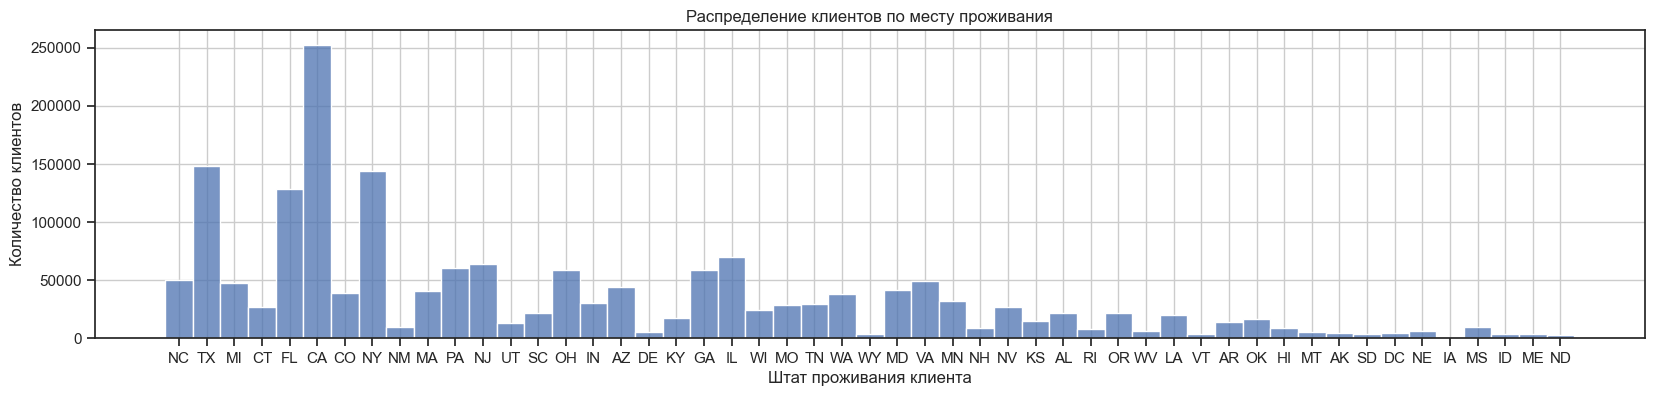

In [166]:
#Посмотрим на распределение признака addr_state с помощью многоуровневой столбчатой диаграммы
fig = plt.figure(figsize=(20,4))
histplot = sns.histplot(data, 
    x='addr_state',
    );

histplot.set_title('Распределение клиентов по месту проживания');
histplot.set_xlabel('Штат проживания клиента');
histplot.set_ylabel('Количество клиентов');
histplot.grid()

> Теперь понятны причины высокой просрочки в указанных штатах. В них просто выдано больше кредитов, чем в других. Так же на графике видно, что в некоторых штатах слишком мало клиентов. Давайте в скольких штататх количество клиентов превышает 1%, 2% и 3% от общего числа записей. 

In [167]:
n = data.shape[0]
s_addr_state = data['addr_state'].value_counts()
print(f' Количество штатов, количество клиентов из которых превышает 1% от общего числа записей:  {s_addr_state[s_addr_state.values > n*0.01].shape[0]}')
print(f' Общее число клиентов в этих штатах:  {s_addr_state[s_addr_state.values > n*0.01].sum()}')
print(f' Количество штатов, количество клиентов из которых превышает 2% от общего числа записей:  {s_addr_state[s_addr_state.values > n*0.02].shape[0]}')
print(f' Общее число клиентов в этих штатах:  {s_addr_state[s_addr_state.values > n*0.02].sum()}')
print(f' Количество штатов, количество клиентов из которых превышает 3% от общего числа записей:  {s_addr_state[s_addr_state.values > n*0.03].shape[0]}')
print(f' Общее число клиентов в этих штатах:  {s_addr_state[s_addr_state.values > n*0.03].sum()}')

 Количество штатов, количество клиентов из которых превышает 1% от общего числа записей:  28
 Общее число клиентов в этих штатах:  1620809
 Количество штатов, количество клиентов из которых превышает 2% от общего числа записей:  17
 Общее число клиентов в этих штатах:  1336708
 Количество штатов, количество клиентов из которых превышает 3% от общего числа записей:  9
 Общее число клиентов в этих штатах:  985120


Как мы и предположили, в более чем 15 штатах клиентов меньше, чем 1 %. Поэтому их можно сгруппировать в графу `'other'`, но если взять этот показатель, у нас всё равно останется слишком большое количество значений (29). Если взять 3%, то в группу `'other'` попадёт более 700 тыс клиентов и она будет слишком многочисленной. Поэтому мы отправим в неё тех клиентов, которые проживают в штатах, где менее 2%. 

In [168]:
#Оставим эти 17 штатов, а в остальных укажем 'other'
state = s_addr_state[s_addr_state.values > n*0.02].index
data['addr_state'] = data['addr_state'].apply (lambda x: x if x in state else 'other')
#Проверим что получилось
display(data['addr_state'].value_counts())

other    456052
CA       252508
TX       148069
NY       144221
FL       128552
IL        70013
NJ        64019
PA        60288
OH        59126
GA        58324
NC        50443
VA        49635
MI        47294
AZ        43991
MD        41927
MA        40632
CO        39189
WA        38477
Name: addr_state, dtype: int64

In [169]:
#теперь можно преобразовать признак с помощью OneHotEncoder
encoder = ce.OneHotEncoder(cols=['addr_state'], use_cat_names=True) 

type_bin = encoder.fit_transform(data['addr_state'])
data = pd.concat([data, type_bin], axis=1)
data[type_bin.columns].head()

,addr_state_NC,addr_state_TX,addr_state_MI,addr_state_other,addr_state_FL,addr_state_CA,addr_state_CO,addr_state_NY,addr_state_MA,addr_state_PA,addr_state_NJ,addr_state_OH,addr_state_AZ,addr_state_GA,addr_state_IL,addr_state_WA,addr_state_MD,addr_state_VA
42536,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42537,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42538,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42539,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
42540,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Показатель zip_code - первые цифры почтового индекса клиента

In [170]:
#Проверим сколько пропусков осталось в этом признаке
print (f"Количество пропущеных строк в признаке zip_code: {data['zip_code'].isnull().sum()}")

Количество пропущеных строк в признаке zip_code: 1


In [171]:
#Определим к какому штату относится данный клиент
state = data[data['zip_code'].isnull() == True]['addr_state']

#Присвоим пропущенному значению наиболее популярный индекс из данного штата
data['zip_code'][state.index[0]] = data[data['addr_state'] == state.values[0]]['zip_code'].value_counts().nlargest(1).index[0]
print (f"Новое значение: {data['zip_code'][state.index[0]]}")
#Проверим действительно ли мы заменили пропуски
print (f"Количество пропущеных строк в признаке zip_code: {data['zip_code'].isnull().sum()}")

Новое значение: 891xx
Количество пропущеных строк в признаке zip_code: 0


In [172]:
#Переведём признак в числовой формат
data['zip_code'] = data['zip_code'].apply (lambda x: int(x[:3]) if type(x) == str else x)
data['zip_code'].value_counts().nlargest(10)

945    19170
750    19012
112    18211
606    16279
300    16193
331    14962
891    14172
70     14093
770    13993
330    13385
Name: zip_code, dtype: int64

По своей сути этот показатель копирует данные из признака addr_state, который мы преобразовали в 18 новых столбков с помощью OneHotEncoder. Рассчитаем матрицу корреляций этих признаков и целевого показателя.

In [173]:
#Создадим список из признаков для матрицы корреляций
columns = list(type_bin.columns)
columns.append('zip_code')
columns.append('loan_status')

#Создадим матрицу корреляций из всех признаков и проверим какие из полученных признаков больше влияют на целевой показатель
corr = data[columns].corr()
corr.style.background_gradient()

,addr_state_NC,addr_state_TX,addr_state_MI,addr_state_other,addr_state_FL,addr_state_CA,addr_state_CO,addr_state_NY,addr_state_MA,addr_state_PA,addr_state_NJ,addr_state_OH,addr_state_AZ,addr_state_GA,addr_state_IL,addr_state_WA,addr_state_MD,addr_state_VA,zip_code,loan_status
addr_state_NC,1.000000,-0.051054,-0.028008,-0.099386,-0.047290,-0.068894,-0.025436,-0.050327,-0.025911,-0.031741,-0.032744,-0.031423,-0.026987,-0.031202,-0.034302,-0.025199,-0.026331,-0.028712,-0.128284,-0.001882
addr_state_TX,-0.051054,1.000000,-0.049390,-0.175258,-0.083392,-0.121487,-0.044855,-0.088747,-0.045692,-0.055972,-0.057740,-0.055412,-0.047589,-0.055022,-0.060488,-0.044437,-0.046432,-0.050631,0.247023,-0.000191
addr_state_MI,-0.028008,-0.049390,1.000000,-0.096147,-0.045749,-0.066648,-0.024608,-0.048687,-0.025067,-0.030706,-0.031676,-0.030399,-0.026107,-0.030185,-0.033184,-0.024378,-0.025473,-0.027776,-0.014902,0.000952
addr_state_other,-0.099386,-0.175258,-0.096147,1.000000,-0.162340,-0.236500,-0.087319,-0.172764,-0.088949,-0.108961,-0.112403,-0.107870,-0.092641,-0.107111,-0.117752,-0.086505,-0.090389,-0.098564,0.047094,0.004467
addr_state_FL,-0.047290,-0.083392,-0.045749,-0.162340,1.000000,-0.112532,-0.041549,-0.082205,-0.042324,-0.051846,-0.053484,-0.051327,-0.044081,-0.050966,-0.056029,-0.041161,-0.043009,-0.046899,-0.161501,-0.013222
addr_state_CA,-0.068894,-0.121487,-0.066648,-0.236500,-0.112532,1.000000,-0.060529,-0.119758,-0.061658,-0.075531,-0.077917,-0.074774,-0.064218,-0.074248,-0.081624,-0.059964,-0.062657,-0.068324,0.541639,0.000388
addr_state_CO,-0.025436,-0.044855,-0.024608,-0.087319,-0.041549,-0.060529,1.000000,-0.044217,-0.022765,-0.027887,-0.028768,-0.027608,-0.023710,-0.027414,-0.030137,-0.022140,-0.023134,-0.025226,0.139603,0.016401
addr_state_NY,-0.050327,-0.088747,-0.048687,-0.172764,-0.082205,-0.119758,-0.044217,1.000000,-0.045042,-0.055176,-0.056919,-0.054623,-0.046912,-0.054239,-0.059627,-0.043804,-0.045771,-0.049911,-0.377400,-0.016778
addr_state_MA,-0.025911,-0.045692,-0.025067,-0.088949,-0.042324,-0.061658,-0.022765,-0.045042,1.000000,-0.028408,-0.029305,-0.028123,-0.024153,-0.027925,-0.030699,-0.022553,-0.023565,-0.025697,-0.241910,0.002564
addr_state_PA,-0.031741,-0.055972,-0.030706,-0.108961,-0.051846,-0.075531,-0.027887,-0.055176,-0.028408,1.000000,-0.035898,-0.034450,-0.029587,-0.034208,-0.037606,-0.027627,-0.028867,-0.031478,-0.202791,-0.002815


> Признак `zip_code` действительно сильно коррелирует с некоторыми признаками штатов. К тому же, только 5 признаков (считая отрицательную корреляцию) из 18 коррелируют с целевым показателем сильнее, чем 1 признак `zip_code`. Поэтому нет смысла оставлять признаки штатов, лучше оставить только признак `zip_code`.

In [174]:
data = data.drop(type_bin.columns, axis=1)
data = data.drop('addr_state', axis=1)
data.shape

(1792760, 37)

### Показатель annual_inc - доход, указанный клиентом при получении кредита

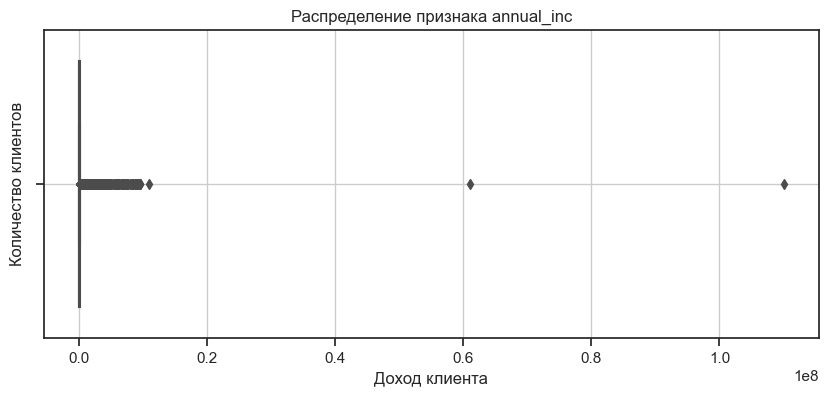

In [175]:
#Проанализируем показатель annual_inc и построим коробчатую диаграмму
fig = plt.figure(figsize=(10, 4))
boxplot = sns.boxplot(data, 
    x='annual_inc',
    );

boxplot.set_title('Распределение признака annual_inc');
boxplot.set_xlabel('Доход клиента');
boxplot.set_ylabel('Количество клиентов');
boxplot.grid()

Прекрасно видно выбросы, которые не дают нормально проанализировать показатель. Так как по этой диаграмме сложно определить точную границу выбросов, воспользуемся методом Тьюки. Так как график явно вытянут вправо сдвинем границы на 0.5 слева и 3.5 справа. 

In [176]:
#Напишем функцию для определения границ с помощью метода Тьюки
def outliers_iqr(data, feature, l_ratio=1.5, r_ratio=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * l_ratio)
    upper_bound = quartile_3 + (iqr * r_ratio)
    return lower_bound, upper_bound

In [177]:
#Применим эту функцию к признаку income и определим границы выбросов
lower_bound, upper_bound = outliers_iqr(data, 'annual_inc', l_ratio=0.5, r_ratio=3)
print(f'Нижняя граница поиска выбросов по методу Тьюки: {lower_bound}')
print(f'Верхняя граница поиска выбросов по методу Тьюки: {upper_bound}')
#Очистим данные от выбросов
mask1=data.annual_inc >= lower_bound
mask2=data.annual_inc <= upper_bound
data = data[mask1 & mask2]
print(f'Количество объектов после отчистки признака от выбросов: {data.shape[0]}')

Нижняя граница поиска выбросов по методу Тьюки: 22900.0
Верхняя граница поиска выбросов по методу Тьюки: 230800.0
Количество объектов после отчистки признака от выбросов: 1721544


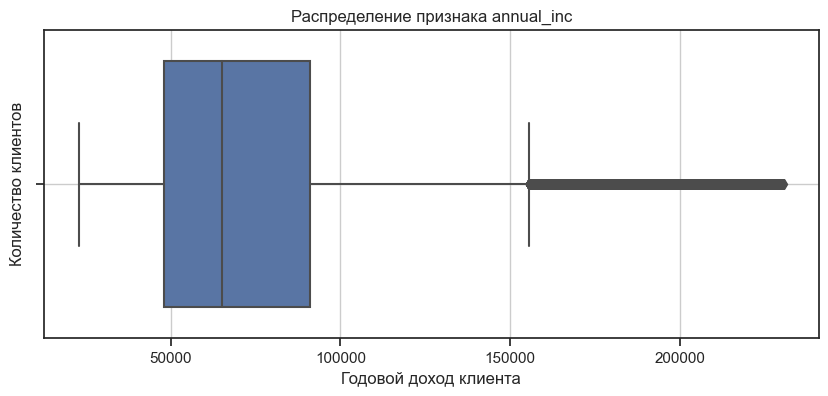

In [178]:
#заново строим коробчатую диаграмму
fig = plt.figure(figsize=(10, 4))
boxplot = sns.boxplot(data, 
    x='annual_inc',
    );

boxplot.set_title('Распределение признака annual_inc');
boxplot.set_xlabel('Годовой доход клиента');
boxplot.set_ylabel('Количество клиентов');
boxplot.grid()

> Хотя данных ниже нижней границы нет, у нас оказалось много значений выше верхней границы и теперь легче анализировать признак. На графике видно, что большая часть клиентов указывала доход от 50 до 90 тысяч. Даже в таком графике есть выбросы, но их значительно меньше, чем до этого. К тому же мы убрали строки с неоправданно низким доходом.

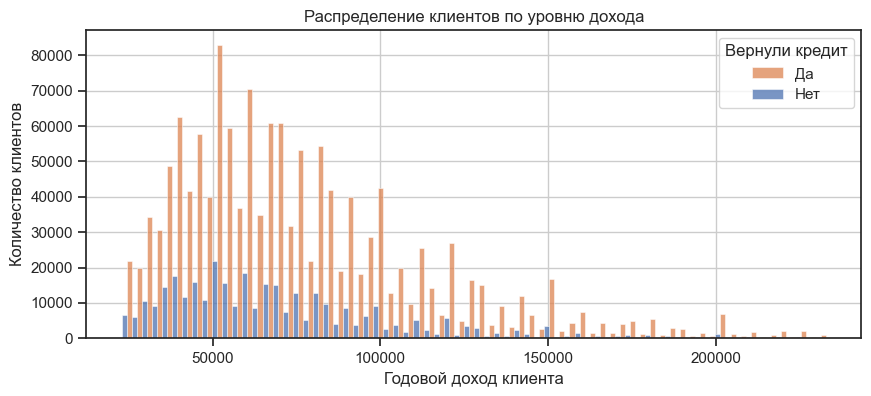

In [179]:
#Посмотрим зависит ли от дохода вернёт кредит заёмщик или нет
#Построим многоуровневую столбчатую диаграмму
fig = plt.figure(figsize=(10,4))
histplot = sns.histplot(data, 
    x='annual_inc',
    hue="loan_status", 
    multiple="dodge",
    binwidth=3000
    );

histplot.set_title('Распределение клиентов по уровню дохода');
histplot.set_xlabel('Годовой доход клиента');
histplot.set_ylabel('Количество клиентов');
histplot.legend( ['Да','Нет'], bbox_to_anchor=(1, 1), title='Вернули кредит');
histplot.grid()

> На графике видно, что уровень дохода влияет на показатель возвратности кредита, так как у людей с высоким уровнем дохода их значительно меньше, чем у людей со средним уровнем доходов.

### Показатель verification_status

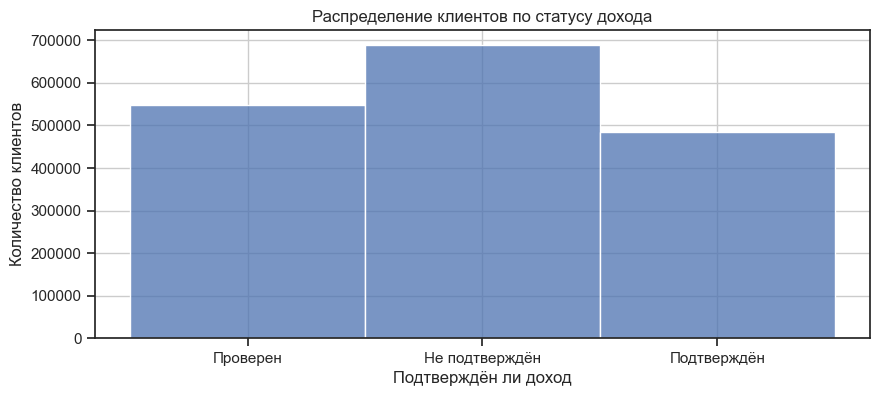

In [180]:
#Посмотрим распределение данных по статусу дохода
fig = plt.figure(figsize=(10,4))
histplot = sns.histplot(data, 
    x='verification_status',
    );

histplot.set_title('Распределение клиентов по статусу дохода');
histplot.set_xlabel('Подтверждён ли доход');
histplot.set_ylabel('Количество клиентов');
histplot.set_xticklabels(['Проверен','Не подтверждён','Подтверждён']);
histplot.grid();

> Как видно по графику не всегда доход подтверждается клиентами. Проверим зависит ли это от суммы запрашиваемого кредита.

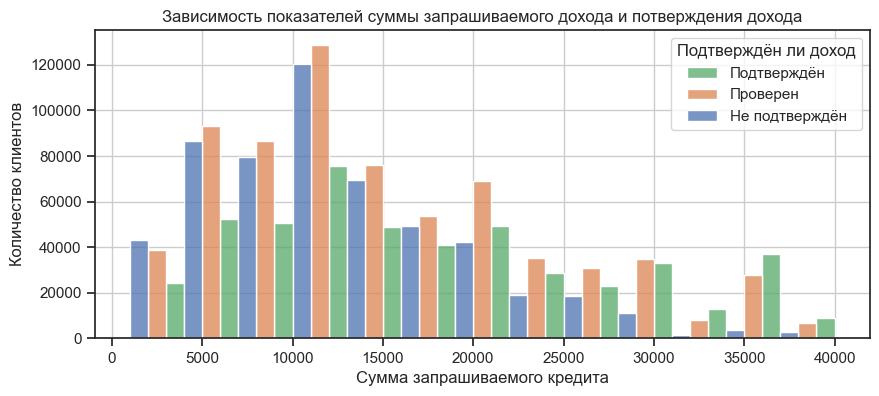

In [181]:
#Посмотрим зависит ли от суммы кредита подтверждение дохода.
#Построим многоуровневую столбчатую диаграмму
fig = plt.figure(figsize=(10,4))
histplot = sns.histplot(data, 
    x='loan_amnt',
    hue="verification_status", 
    multiple="dodge",
    binwidth=3000
    );

histplot.set_title('Зависимость показателей суммы запрашиваемого дохода и потверждения дохода');
histplot.set_xlabel('Сумма запрашиваемого кредита');
histplot.set_ylabel('Количество клиентов');
histplot.legend(['Подтверждён','Проверен','Не подтверждён'], bbox_to_anchor=(1, 1), title='Подтверждён ли доход');
histplot.grid()

По графику видно, что чем выше сумма, тем ниже доля клиентов с неподтверждённым доходом. А при запросе большой суммы процент клиентов с неподтверждённым доходом очень мал. 

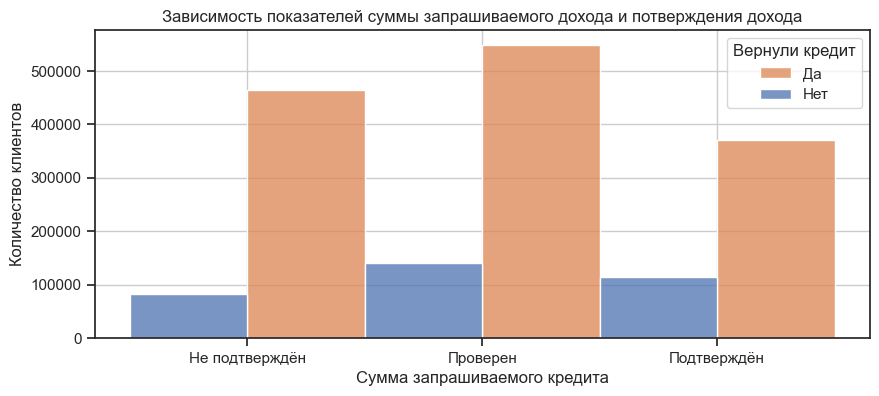

In [182]:
#Посмотрим зависит ли выход на просрочку от подтверждение дохода.
#Построим многоуровневую столбчатую диаграмму
fig = plt.figure(figsize=(10,4))
histplot = sns.histplot(data, 
    x='verification_status',
    hue="loan_status", 
    multiple="dodge",
    binwidth=3000
    );

histplot.set_title('Зависимость показателей суммы запрашиваемого дохода и потверждения дохода');
histplot.set_xlabel('Сумма запрашиваемого кредита');
histplot.set_ylabel('Количество клиентов');
histplot.set_xticklabels(['Не подтверждён','Проверен','Подтверждён']);
histplot.legend(['Да','Нет'], bbox_to_anchor=(1, 1), title='Вернули кредит');
histplot.grid()

> Мы видим, что даже среди клиентов с неподтверждённым доходом доля просрочки не выше, а даже ниже, чем при подтверждёненом и проверенном. Перекодируем этот показатель с помощью OneHotEncoder.

In [183]:
#теперь можно преобразовать признак с помощью OneHotEncoder
encoder = ce.OneHotEncoder(cols=['verification_status'], use_cat_names=True) 

type_bin = encoder.fit_transform(data['verification_status'])
data = pd.concat([data, type_bin], axis=1)
data = data.drop('verification_status', axis=1)
data[type_bin.columns].head()

,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified
42536,1,0,0
42537,0,1,0
42538,0,0,1
42539,1,0,0
42540,1,0,0


### Показатель dti - доля в доходе клиента, которую он тратит на погашение кредитов

In [184]:
#Проверим сколько пропусков осталось в этом признаке
print (f"Количество пропущеных строк в признаке dti: {data['dti'].isnull().sum()}")

Количество пропущеных строк в признаке dti: 0


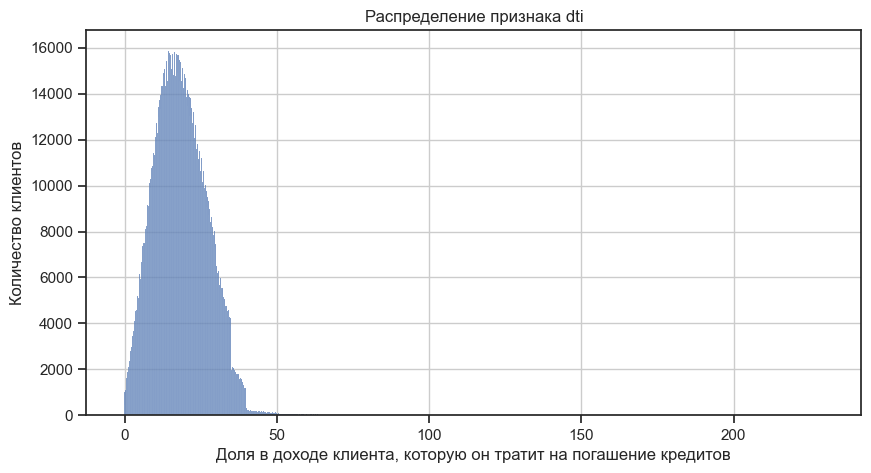

In [185]:
#Посмотрим на распределение признака dti
fig = plt.figure(figsize=(10,5))
histplot = sns.histplot(data,
    x='dti',
    );

histplot.set_title('Распределение признака dti');
histplot.set_xlabel('Доля в доходе клиента, которую он тратит на погашение кредитов');
histplot.set_ylabel('Количество клиентов');
histplot.grid()

> По графику видно, что большая часть клиентов тратит на погашение кредитов до 50 % своих доходов. Низкое значение данного показателя означает, что у клиента нет или очень мало кредитных обязательств. При этом, при показателе в 36 клиенту уже скорее всего откажут в кредите. А выше 40 сразу последует отказ. Поэтому все данные меньше 0 и больше 40 являются выбросами. Необходимо удалить их.

In [186]:
#Очистим данные от выбросов
mask1=data.dti > 0 
mask2=data.dti <= 40
data = data[mask1 & mask2]
print(f'Количество объектов после отчистки признака от выбросов: {data.shape[0]}')

Количество объектов после отчистки признака от выбросов: 1708379


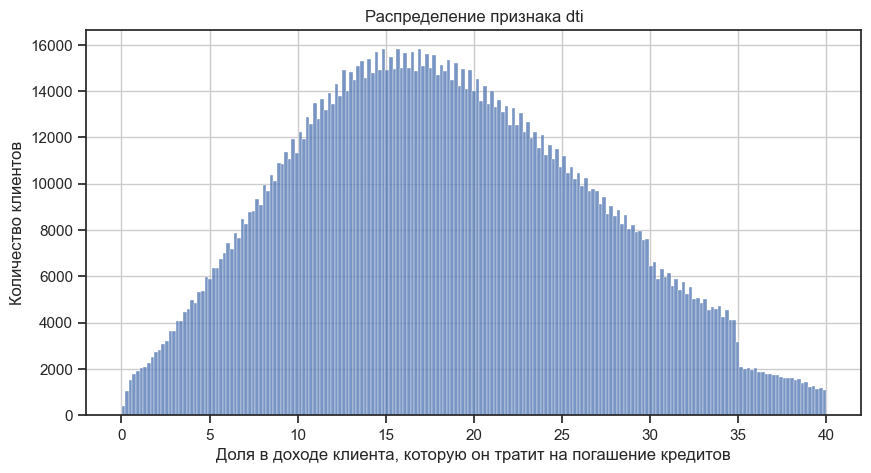

In [187]:
#Посмотрим на распределение признака dti после отчистки
fig = plt.figure(figsize=(10,5))
histplot = sns.histplot(data,
    x='dti',
    );

histplot.set_title('Распределение признака dti');
histplot.set_xlabel('Доля в доходе клиента, которую он тратит на погашение кредитов');
histplot.set_ylabel('Количество клиентов');
histplot.grid()

> Мы получили более реальную картину. в среднем люди тратят на погашение кредитов от 7 до 30 тысяч. Посомтрим, на что расходуются эти деньги.

### Группа показателей, связанных с количеством кредитов:
- `mort_acc` - количество ипотечных кредитов.
- `num_actv_bc_tl` - количество действующих в настоящее время карточных счетов;
- `total_acc` - общее количество кредитных линий в НБКИ зёмщика;
- `num_sats` - количестов счетов без просрочки;
- `num_tl_op_past_12m` - количество кредитов, полученных в последние 12 месяцев;
- `num_rev_accts` - количество возобновляемых счетов;
- `percent_bc_gt_75` - на скольких кредитных картах выбрано больше 75% от лимита;
- `tax_liens` - число залогов;
- `open_acc` - количество открытых кредитных линий заемщика;
- `revol_util` - процент использования возобновляемой линии или сумма, которую использует заемщик, по отношению ко всем имеющимся возобновляемым кредитам;
- `collections_12_mths_ex_med` - количество предоставленных за последний год документов.

Эти показатели должны быть тесно связаны между собой. Посмотрим так ли это и как они влияют на целевой показатель с помощью матрицы корреляции. Но перед этим очистим данные от пропусков

In [188]:
#Проверим сколько осталось пустых данных в показателях
data[['revol_util','num_rev_accts','percent_bc_gt_75']].isnull().sum()

revol_util           1100
num_rev_accts           1
percent_bc_gt_75    18998
dtype: int64

In [189]:
#Заменим это значение на медианное в признаке num_rev_accts 
index = data[data['num_rev_accts'].isnull()]['num_rev_accts'].index[0]
data['num_rev_accts'][index] = data['num_rev_accts'].median()

# и percent_bc_gt_75
index = data[data['percent_bc_gt_75'].isnull()]['percent_bc_gt_75'].index
value = data['percent_bc_gt_75'].median()
for i in index:
    data['percent_bc_gt_75'][i] = value

# и revol_util
index = data[data['revol_util'].isnull()]['revol_util'].index
value = data['revol_util'].mode()
for i in index:
    data['revol_util'][i] = value
data[['revol_util','num_rev_accts','percent_bc_gt_75']].isnull().sum()

revol_util          0
num_rev_accts       0
percent_bc_gt_75    0
dtype: int64

In [190]:
data = data.assign(
    revol_util = pd.to_numeric(data['revol_util'].str.replace('[^0-9.]', ''))
)
data['revol_util']

42536      24.0
42537      16.1
42538      61.2
42539      55.7
42540      81.9
           ... 
2925488    24.9
2925489    15.7
2925490    47.0
2925491    10.1
2925492    72.6
Name: revol_util, Length: 1708379, dtype: float64

In [191]:
#Создадим список из признаков для матрицы корреляций
columns = ['mort_acc', 'num_actv_bc_tl','total_acc', 'open_acc' , 'num_sats', 'num_tl_op_past_12m',
           'num_rev_accts', 'collections_12_mths_ex_med', 'percent_bc_gt_75', 'tax_liens', 'revol_util', 'loan_status']

#Создадим матрицу корреляций из всех признаков и проверим какие из полученных признаков больше влияют на целевой показатель
corr = data[columns].corr()
corr.style.background_gradient()

,mort_acc,num_actv_bc_tl,total_acc,open_acc,num_sats,num_tl_op_past_12m,num_rev_accts,collections_12_mths_ex_med,percent_bc_gt_75,tax_liens,revol_util,loan_status
mort_acc,1.000000,0.028650,0.355727,0.114962,0.112795,0.055270,0.214786,-0.014128,0.011259,-0.013464,0.030415,0.072041
num_actv_bc_tl,0.028650,1.000000,0.292784,0.545772,0.544818,0.162840,0.452409,-0.006237,0.037758,0.010586,0.107274,-0.043277
total_acc,0.355727,0.292784,1.000000,0.704667,0.701229,0.330539,0.761892,0.004438,-0.066358,-0.022075,-0.108782,0.013241
open_acc,0.114962,0.545772,0.704667,1.000000,0.998857,0.369281,0.656820,0.006992,-0.092772,-0.008730,-0.147957,-0.023716
num_sats,0.112795,0.544818,0.701229,0.998857,1.000000,0.367520,0.651619,0.006266,-0.093039,-0.008736,-0.147846,-0.023460
num_tl_op_past_12m,0.055270,0.162840,0.330539,0.369281,0.367520,1.000000,0.303790,0.013017,-0.177304,0.014544,-0.224647,-0.083614
num_rev_accts,0.214786,0.452409,0.761892,0.656820,0.651619,0.303790,1.000000,-0.002343,-0.112203,-0.017006,-0.175265,0.002244
collections_12_mths_ex_med,-0.014128,-0.006237,0.004438,0.006992,0.006266,0.013017,-0.002343,1.000000,-0.031281,0.011155,-0.035543,-0.014323
percent_bc_gt_75,0.011259,0.037758,-0.066358,-0.092772,-0.093039,-0.177304,-0.112203,-0.031281,1.000000,-0.010778,0.731093,-0.054297
tax_liens,-0.013464,0.010586,-0.022075,-0.008730,-0.008736,0.014544,-0.017006,0.011155,-0.010778,1.000000,-0.004192,-0.006574


In [192]:
#Посмотрим статистику показателей
data[columns].describe()[1:].T

,mean,std,min,25%,50%,75%,max
mort_acc,1.608336,1.925372,0.0,0.0,1.0,3.0,51.0
num_actv_bc_tl,3.645602,2.274604,0.0,2.0,3.0,5.0,50.0
total_acc,24.780255,11.985106,2.0,16.0,23.0,31.0,176.0
open_acc,11.715009,5.570036,0.0,8.0,11.0,14.0,90.0
num_sats,11.671086,5.555244,0.0,8.0,11.0,14.0,90.0
num_tl_op_past_12m,2.161306,1.854295,0.0,1.0,2.0,3.0,32.0
num_rev_accts,14.322063,8.089371,1.0,8.0,13.0,18.0,128.0
collections_12_mths_ex_med,0.018718,0.152223,0.0,0.0,0.0,0.0,20.0
percent_bc_gt_75,42.962484,35.936654,0.0,0.0,40.0,71.4,100.0
tax_liens,0.050738,0.394544,0.0,0.0,0.0,0.0,85.0


> Как мы и предполагали большинство показателей сильно корелируют между собой. Можно выделить сразу 4 показателя с сильной связью. Это `total_acc`, `open_acc`, `num_sats` и `num_rev_accts`. Из всех этих показтелей, я бы оставила только `total_acc`. Во-первых, его влияние на другие показатели ниже, чем у других. Во-вторых, у него наибольшая прямая зависимость от целевого показателя. А в-третьих, больше разброс значений.  К моему удивлению, у показателей `mort_acc` и `tax_liens` практически нет зависимости. Из показателей `revol_util` и `percent_bc_gt_75` оставим revol_util. Так как в показателе `percent_bc_gt_75` слишком много нулевых хначений. Стоит также отметить, что показатели `mort_acc` и `num_tl_op_past_12m` сильнее всех влияют на целевой показатель.

In [193]:
#удалим показатели open_acc, num_sats, num_rev_accts
data = data.drop(['open_acc','num_sats','num_rev_accts', 'percent_bc_gt_75'], axis=1)
data.shape

(1708379, 35)

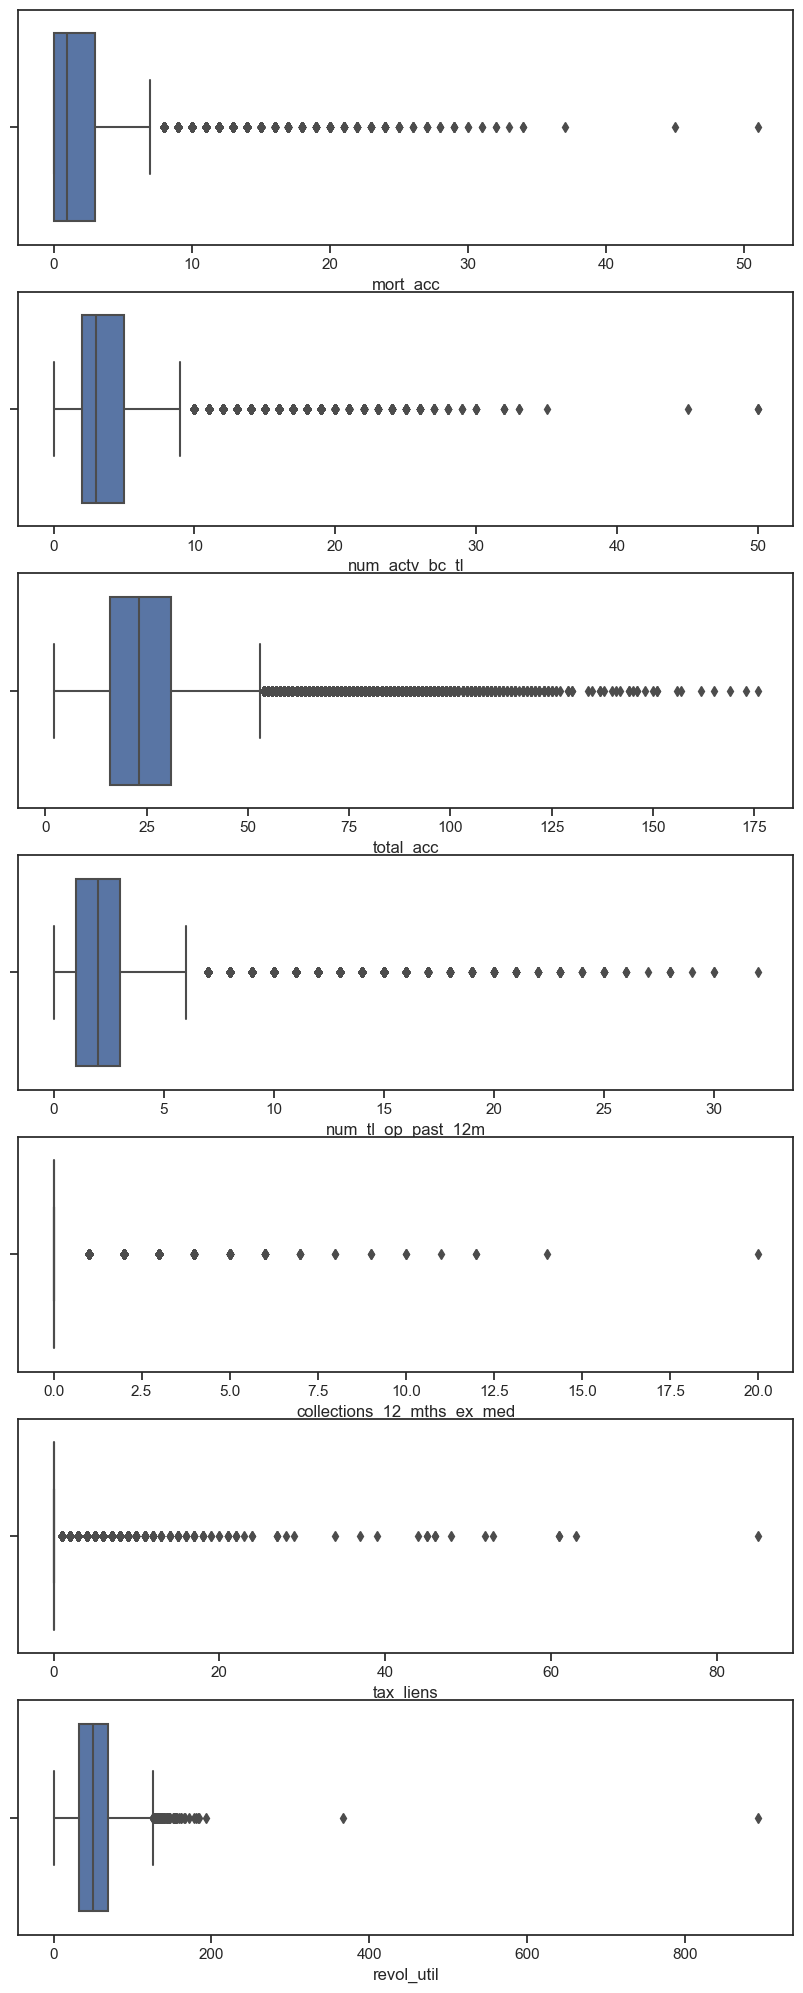

In [194]:
columns = ['mort_acc', 'num_actv_bc_tl','total_acc', 'num_tl_op_past_12m',
           'collections_12_mths_ex_med', 'tax_liens', 'revol_util']

#Построим коробчатые диаграммы по признакам 
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 25))
for i,v in enumerate (columns):
    sns.boxplot(data, 
        x=v,
        ax=axes[i]
        );

> Видим, что большинства показателей присутсвуют выбросы. Показатели `collections_12_mths_ex_med` и `tax_liens` проанализируем отдельно, так как в нём коробки слишком смещена вправо. Остальные показатели отчистим от выбросов, установив верхнюю границу коэфициента по методу Тьюки = 2. Нижняя граница нас не интересует. 

In [195]:
columns = ['mort_acc', 'num_actv_bc_tl', 'total_acc', 'num_tl_op_past_12m', 'revol_util']

for i in columns:
    lower_bound, upper_bound = outliers_iqr(data, i, r_ratio=2)
    print(f'Верхняя граница поиска выбросов по методу Тьюки в признаке: {i} = {upper_bound}')
    mask2=data[i] <= upper_bound
    data = data[mask2]
print(f'Количество объектов после отчистки признака от выбросов: {data.shape[0]}')

Верхняя граница поиска выбросов по методу Тьюки в признаке: mort_acc = 9.0
Верхняя граница поиска выбросов по методу Тьюки в признаке: num_actv_bc_tl = 11.0
Верхняя граница поиска выбросов по методу Тьюки в признаке: total_acc = 61.0
Верхняя граница поиска выбросов по методу Тьюки в признаке: num_tl_op_past_12m = 7.0
Верхняя граница поиска выбросов по методу Тьюки в признаке: revol_util = 144.7
Количество объектов после отчистки признака от выбросов: 1652217


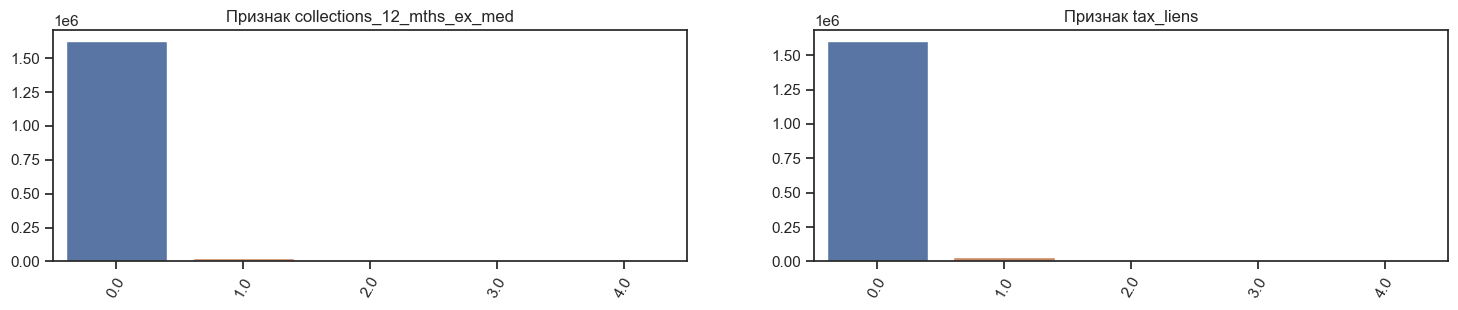

In [196]:
#Посмотрим на 10 самых популярных категорий в показателях
values_coll = data['collections_12_mths_ex_med'].value_counts().nlargest(5)
values_tax = data['tax_liens'].value_counts().nlargest(5)

#Построим коробчатые диаграммы по признакам 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
a = sns.barplot(x = values_coll.index, y = values_coll.values, ax=axes[0]);
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title('Признак collections_12_mths_ex_med');
b = sns.barplot(x = values_tax.index, y = values_tax.values, ax=axes[1]);
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title('Признак tax_liens');

> Как видим, в данных показателя превуалирует значение 0 оно составлет более 95% от значений показателя. Теперь понятно, почему у них такая низкая корреляция с целевым показателем. Их лучше удалить.

In [197]:
data = data.drop(['tax_liens','collections_12_mths_ex_med'], axis=1)
data.shape

(1652217, 33)

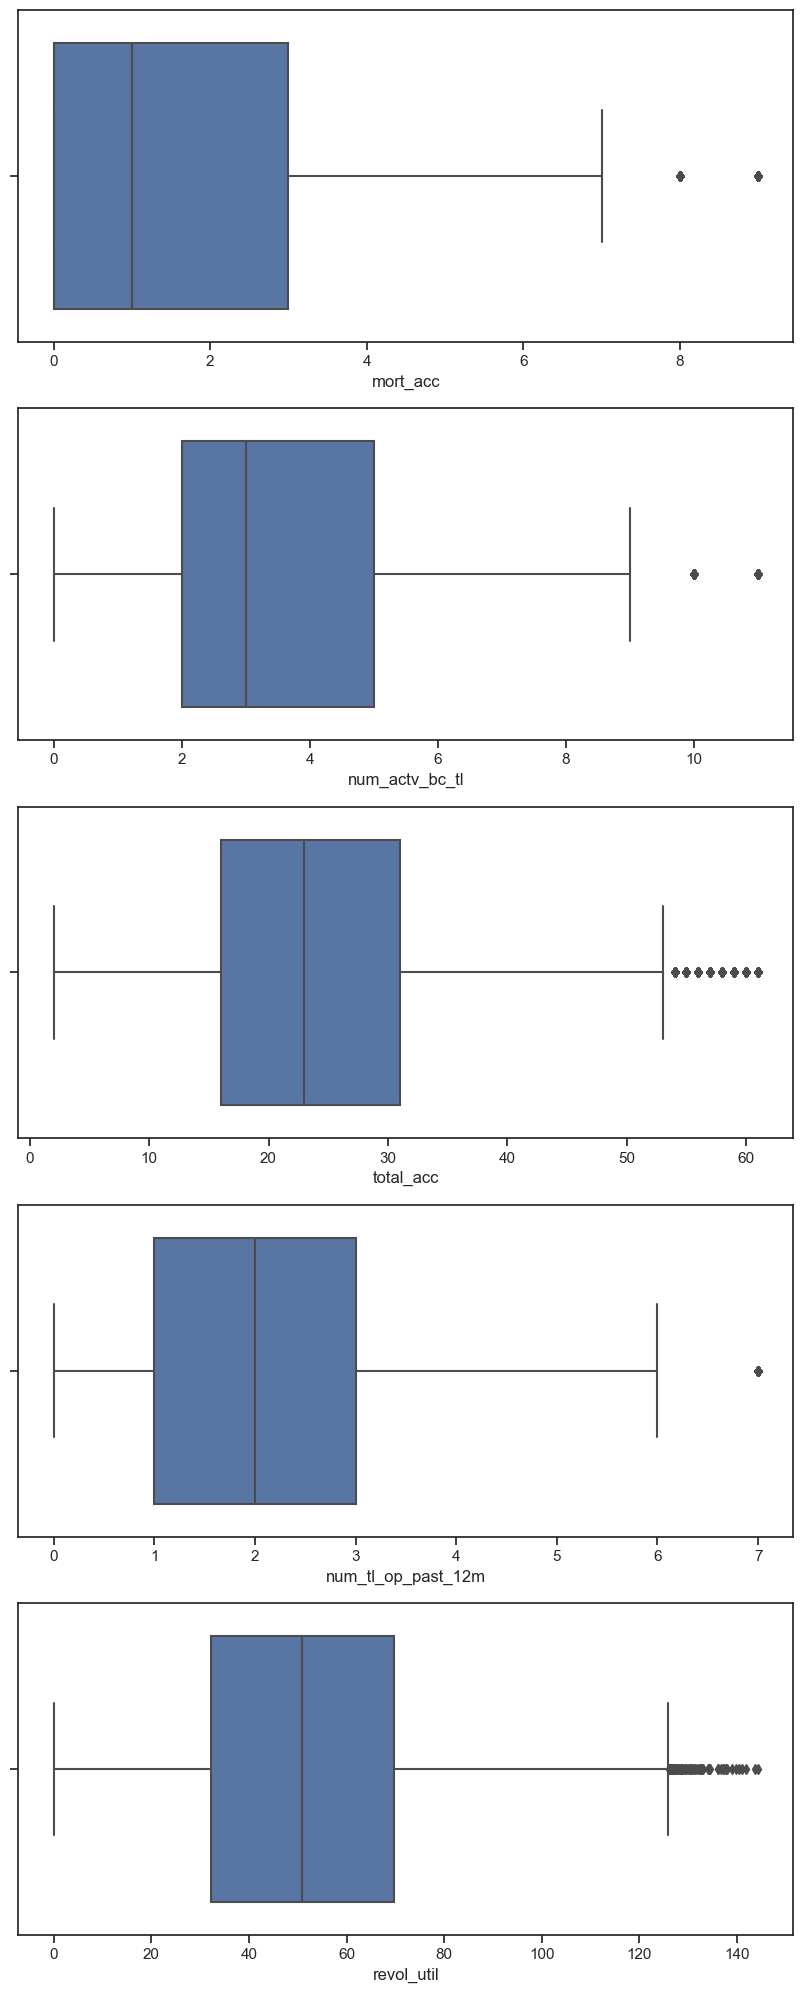

In [198]:
#Построим коробчатые диаграммы по признакам снова
fig, axes = plt.subplots(nrows=len(columns), ncols=1, figsize=(10, 25))
for i,v in enumerate (columns):
    sns.boxplot(data, 
        x=v,
        ax=axes[i]
        );

> Теперь можно сказать, что у клиентов в среднем от 15 до 30 кредитов в НБКИ, из которых от 1 до 3 открыты в последний год, от 0 до 4 составляют ипотечные кредиты, от 2 до 4 активный кредитов. Стоит отметить, что в НБКИ отражаются все кредиты, которые заёмщик когда-либо оформлял на себя. Плюс некоторые кредиты могут отражаться по несколько раз, а ипотека будет отражаться у созаёмщиков, так что такая картина вполне уместна.

### Показатель home_ownership - cтатус собственности, в которой проживает клиент на момент выдачи кредита

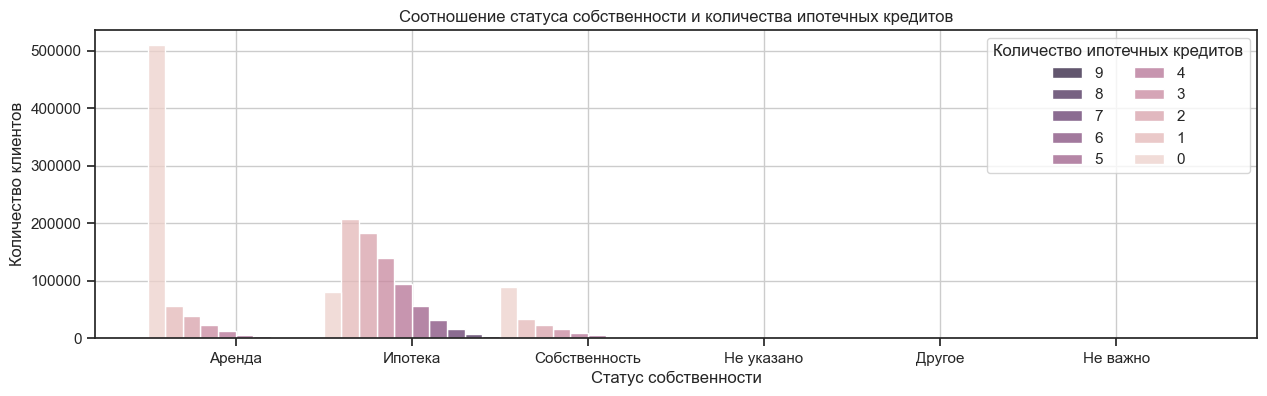

In [199]:
#Посмотрим соотношение статуса собстенности и количества ипотечных кредитов
fig, ax = plt.subplots(figsize=(15,4))
histplot = sns.histplot(data, 
    x='home_ownership',
    hue="mort_acc", 
    multiple="dodge",
    binwidth=5000,
    );

histplot.set_title('Соотношение статуса собственности и количества ипотечных кредитов');
histplot.set_xlabel('Статус собственности');
histplot.set_ylabel('Количество клиентов');
histplot.legend(labels = [9,8,7,6,5,4,3,2,1,0], 
                ncol=2, 
                title='Количество ипотечных кредитов');
histplot.set_xticklabels(['Аренда','Ипотека','Собственность','Не указано', 'Другое', 'Не важно']);
histplot.grid()

> Судя по графику складывается очень интересная картина. Среди клиентов, указавших, что проживают в арендованной квартире, встречаются те, у кого есть по несколько ипотек. При этом есть и люди, которые указали, что живут в ипотечной квартире, но при этом не имеют ни одного договора. Так же отметим, что записей в трёх последних категориях так мало, что они не отразились на графике. Проверим их количество и если оно не значительно, удалим. 

In [200]:
#Определим количество записей в 3 группах показателя с минимальными значениями
values = data[(data['home_ownership'] != 'RENT') & (data['home_ownership'] != 'OWN') & (data['home_ownership'] != 'MORTGAGE')]
print (f"Колиечство клиентов, проживающих в ипотечной квартире, но не имеющих ипотечных договоров: {values.shape[0]}")

Колиечство клиентов, проживающих в ипотечной квартире, но не имеющих ипотечных договоров: 1146


> Таких клиентов меньше процента от общего количества. Поэтому проще удалить эти записи.

In [201]:
data=data.drop(values.index, axis=0)
data.shape

(1651071, 33)

In [202]:
#теперь можно преобразовать признак с помощью OneHotEncoder и удалить признак home_ownership
encoder = ce.OneHotEncoder(cols=['home_ownership'], use_cat_names=True) 

type_bin = encoder.fit_transform(data['home_ownership'])
data = pd.concat([data, type_bin], axis=1)
data = data.drop('home_ownership',axis=1)
data[type_bin.columns].head()

,home_ownership_RENT,home_ownership_MORTGAGE,home_ownership_OWN
42536,1,0,0
42537,0,1,0
42538,0,0,1
42539,0,1,0
42540,1,0,0


### Группа признаков, указывающая на просрочки клиента:
- `acc_now_delinq` - количество просрочек клиента;
- `chargeoff_wtihin_12_mths` - количество списаний невозвратных кредитов по банкротству за последний год;
- `num_accts_ever_120_pd` - количество кредитов, просроченных на 120 или более дней;
- `delinq_2yrs` - количество допущенных просрочек более 30 дней за последние два года;
- `num_tl_90g_dpd_24m` - количество кредитов, просроченных на 90 или более дней за последние два года;
- `pub_rec` - количество невыплаченных и присуждённых судом долгов;
- `pub_rec_bankruptcies` - количество банкротств, зарегистрированных в официальных документах;

Эти показатели должны быть тесно связаны между собой. Посмотрим так ли это и как они влияют на целевой показатель с помощью матрицы корреляции.

In [203]:
#Создадим список из признаков для матрицы корреляций
columns = ['acc_now_delinq', 'chargeoff_within_12_mths','num_accts_ever_120_pd' , 'delinq_2yrs', 'num_tl_90g_dpd_24m',
           'pub_rec','pub_rec_bankruptcies', 'loan_status']

#Создадим матрицу корреляций из всех признаков и проверим какие из полученных признаков больше влияют на целевой показатель
corr = data[columns].corr()
corr.style.background_gradient()

,acc_now_delinq,chargeoff_within_12_mths,num_accts_ever_120_pd,delinq_2yrs,num_tl_90g_dpd_24m,pub_rec,pub_rec_bankruptcies,loan_status
acc_now_delinq,1.000000,0.036484,0.022023,0.121270,0.058524,-0.001012,-0.010220,-0.001666
chargeoff_within_12_mths,0.036484,1.000000,0.122124,0.145501,0.219421,-0.006889,-0.012644,-0.003724
num_accts_ever_120_pd,0.022023,0.122124,1.000000,0.216777,0.313303,0.014408,-0.031307,-0.010046
delinq_2yrs,0.121270,0.145501,0.216777,1.000000,0.654652,-0.025578,-0.053301,-0.014570
num_tl_90g_dpd_24m,0.058524,0.219421,0.313303,0.654652,1.000000,-0.004468,-0.013708,-0.008848
pub_rec,-0.001012,-0.006889,0.014408,-0.025578,-0.004468,1.000000,0.654964,-0.022430
pub_rec_bankruptcies,-0.010220,-0.012644,-0.031307,-0.053301,-0.013708,0.654964,1.000000,-0.025396
loan_status,-0.001666,-0.003724,-0.010046,-0.014570,-0.008848,-0.022430,-0.025396,1.000000


> Мы видим, что признаки `delinq_2yrs` и `num_tl_90g_dpd_24m`, а так же `pub_rec` и `pub_rec_bankruptcies` сильно корелированы между собой. Это объяснимо тем, что не так много клиентов, вышедших на просрочку более 30 дней могут вновь вернуться в график. Обычно, такие длительные просрочки связаны с ухудшением материального положения и банкротством клиента сразу по несокльким обяззательствам. 

In [204]:
#посмотрим статистику по этим показателям
data[columns].describe()[1:].T

,mean,std,min,25%,50%,75%,max
acc_now_delinq,0.004792,0.074801,0.0,0.0,0.0,0.0,14.0
chargeoff_within_12_mths,0.009162,0.109748,0.0,0.0,0.0,0.0,10.0
num_accts_ever_120_pd,0.506815,1.332835,0.0,0.0,0.0,0.0,39.0
delinq_2yrs,0.320868,0.880496,0.0,0.0,0.0,0.0,39.0
num_tl_90g_dpd_24m,0.086302,0.494362,0.0,0.0,0.0,0.0,39.0
pub_rec,0.213127,0.594346,0.0,0.0,0.0,0.0,86.0
pub_rec_bankruptcies,0.136298,0.377445,0.0,0.0,0.0,0.0,12.0
loan_status,0.806284,0.395209,0.0,1.0,1.0,1.0,1.0


> У всех показателей более 75 % данных составляют 0. Посмотрим на количество таких записей:

In [205]:
for i in columns:
    count = data[data[i] == 0][i].count()
    percent = count / data.shape[0] * 100
    print (f'В показателе {i} нулевых значений: {count}. Это {round(percent,2)}% от признака') 

В показателе acc_now_delinq нулевых значений: 1643664. Это 99.55% от признака
В показателе chargeoff_within_12_mths нулевых значений: 1637545. Это 99.18% от признака
В показателе num_accts_ever_120_pd нулевых значений: 1263592. Это 76.53% от признака
В показателе delinq_2yrs нулевых значений: 1330423. Это 80.58% от признака
В показателе num_tl_90g_dpd_24m нулевых значений: 1559019. Это 94.42% от признака
В показателе pub_rec нулевых значений: 1371217. Это 83.05% от признака
В показателе pub_rec_bankruptcies нулевых значений: 1441133. Это 87.28% от признака
В показателе loan_status нулевых значений: 319839. Это 19.37% от признака


> По полученным данным, что в трёх признаках `acc_now_delinq`, `chargeoff_within_12_mths` и `num_tl_90g_dpd_24m` менее 6 процентов Не нулевых значений. а это очень малое количество данных. Если выбирать из двух сильно корелирующих признаков `pub_rec` и `pub_rec_bankruptcies`, то в последнем больше нулевых значений. а значит, его следует удалить.


In [206]:
data = data.drop(['acc_now_delinq','chargeoff_within_12_mths','num_tl_90g_dpd_24m','pub_rec_bankruptcies'], axis=1)
data.shape

(1651071, 31)

### Признаки fico_range_high и fico_range_low - верхняя и нижняя границы кредитного рейтинга
Эти показатели должны сильно корелироваться между собой. Проверим так ли это.

In [207]:
#Создадим список из признаков для матрицы корреляций
columns = ['fico_range_high', 'fico_range_low', 'loan_status']

#Создадим матрицу корреляций из всех признаков и проверим какие из полученных признаков больше влияют на целевой показатель
corr = data[columns].corr()
corr.style.background_gradient()

,fico_range_high,fico_range_low,loan_status
fico_range_high,1.000000,1.000000,0.118844
fico_range_low,1.000000,1.000000,0.118846
loan_status,0.118844,0.118846,1.000000


> Прекрасная картина. Показатели полностью связаны между собой. Так как трудно оценить какой из них важнее, мы возмём среднее от 2 показателей.

In [208]:
#Создадим новый признак
data ['fico_range'] = (data ['fico_range_high']+data ['fico_range_low'])/2
#И удалим предыдущие
data = data.drop(['fico_range_high','fico_range_low'], axis=1)
print (f"Среднее значение показателя fico_range: {round(data['fico_range'].mean(),2)}")

Среднее значение показателя fico_range: 699.08


### Признаки отвечающие за вновь выдаваемый кредит:
- `installment` - платёж по запрашиваемому кредиту;
- `funded_amnt` - сумма кредита, согласованная к выдаче;
- `loan_amnt` - сумма кредита, запрашиваемая клиентом;
- `int_rate` - процентная ставка по кредиту;
- `term` - количество платежей по кредиту. Стоимость в месяцах и может быть 36 или 60.
- `issue_d` - дата выдачи кредита.

Так как два последних показателя типа object сначала переведём их в число, а затем проанализируем все показатели с помощью матрицы корреляций.

In [209]:
#выделим из признака issue_d год и месяц
data['issue_d'] = pd.to_datetime(data['issue_d'])
data['year_issue_d'] = data['issue_d'].dt.year
data['mnth_issue_d'] = data['issue_d'].dt.month

In [210]:
#Изменим признак int_rate
data['int_rate'] = data['int_rate'].apply(lambda x: float(x.replace('%','')))
data['int_rate'].head()

42536    10.99
42537    10.99
42538    10.99
42539     7.62
42540    12.85
Name: int_rate, dtype: float64

In [211]:
data['term'] = data['term'].apply(lambda x: 0 if x==' 36 months' else 1)
data['term'].value_counts()

0    1230972
1     420099
Name: term, dtype: int64

In [212]:
#Создадим список из признаков для матрицы корреляций
columns = ['installment', 'funded_amnt', 'loan_amnt', 'int_rate', 'term', 'year_issue_d','mnth_issue_d','loan_status']

#Создадим матрицу корреляций из всех признаков и проверим какие из полученных признаков больше влияют на целевой показатель
corr = data[columns].corr()
corr.style.background_gradient()

,installment,funded_amnt,loan_amnt,int_rate,term,year_issue_d,mnth_issue_d,loan_status
installment,1.000000,0.950201,0.950200,0.149729,0.140175,-0.005060,-0.022342,-0.065021
funded_amnt,0.950201,1.000000,0.999999,0.130863,0.386623,-0.009288,-0.021708,-0.078124
loan_amnt,0.950200,0.999999,1.000000,0.130862,0.386623,-0.009288,-0.021708,-0.078123
int_rate,0.149729,0.130863,0.130862,1.000000,0.399411,-0.043772,0.017171,-0.254041
term,0.140175,0.386623,0.386623,0.399411,1.000000,-0.041421,0.004993,-0.172782
year_issue_d,-0.005060,-0.009288,-0.009288,-0.043772,-0.041421,1.000000,-0.168153,-0.035444
mnth_issue_d,-0.022342,-0.021708,-0.021708,0.017171,0.004993,-0.168153,1.000000,-0.004576
loan_status,-0.065021,-0.078124,-0.078123,-0.254041,-0.172782,-0.035444,-0.004576,1.000000


> По полученной матрице видно, что три показателя сильно корелируют между собой. При этом у показателя `installment` ниже влияние на другие показатели, поэтому оставим его. Из новых показателей о дате выдачи кредита оставим только `year_issue_d`, потому что у `mnth_issue_d` слишком маленькое влияние на целевой показатель.

In [213]:
#Удалим лишние колонки из датасета
data = data.drop(['funded_amnt', 'loan_amnt', 'mnth_issue_d', 'issue_d'], axis=1)
data.shape

(1651071, 28)

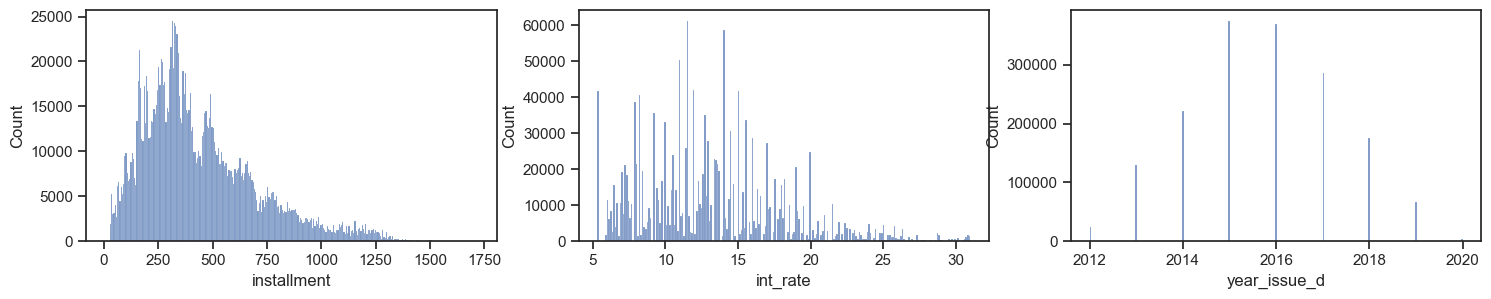

In [214]:
##Обновим список колонок и построим гистограммы по признакам 
columns = ['installment', 'int_rate', 'year_issue_d'] 

fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(18, 3))
for i,v in enumerate (columns):
    sns.histplot(data, 
        x=v,
        ax=axes[i]
        );

> Как видим и тут не обошлось без выбросов. В показателе `installment` смущают и слишком большие, и слишком маленькие суммы. А в показателе `int_rate` процентная ставка более 30%. Очистим данные с помощбю метода Тьюки. Значение правого коэфицинета установим 2. А в показателе `installment` поставим левую границу = 100. То есть клиентов с ежемесячным платежом менее 100 удалим. Так же отметим, что у нас имеются данные о кредитах с 2012 по 2020 год. Причём большая их часть приходится на 2015-2017 года.

In [215]:
#Очистим признак installment от выбросов 
lower_bound, upper_bound = outliers_iqr(data, 'installment', r_ratio=2)
print(f'Верхняя граница поиска выбросов по методу Тьюки: {upper_bound}')
mask1=data.installment >= 100
mask2=data.installment <= upper_bound
data = data[mask1 & mask2]

#Очистим признак installment от выбросов 
lower_bound, upper_bound = outliers_iqr(data, 'int_rate', r_ratio=2)
print(f'Верхняя граница поиска выбросов по методу Тьюки: {upper_bound}')
mask2 = data.int_rate <= upper_bound
data = data[mask2]

print(f'Количество объектов после отчистки признака от выбросов: {data.shape[0]}')

Верхняя граница поиска выбросов по методу Тьюки: 1240.4500000000003
Верхняя граница поиска выбросов по методу Тьюки: 28.990000000000002
Количество объектов после отчистки признака от выбросов: 1564635


### Признаки описывающие кредит:
- `title` - Описание цели кредита заёмщиком
- `purpose` - Описание цели кредита банком

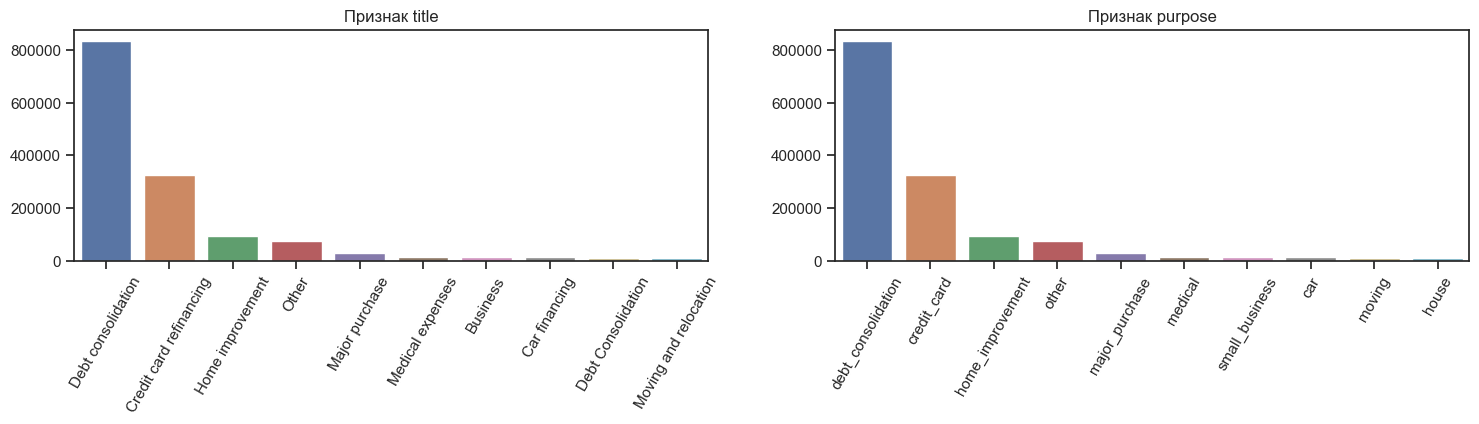

In [216]:
#Посмотрим на 10 самых популярных категорий в показателях
values_title = data['title'].value_counts().nlargest(10)
values_purpose = data['purpose'].value_counts().nlargest(10)

#Построим коробчатые диаграммы по признакам 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
a = sns.barplot(x = values_title.index, y = values_title.values, ax=axes[0]);
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title('Признак title');
b = sns.barplot(x = values_purpose.index, y = values_title.values, ax=axes[1]);
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title('Признак purpose');

> Как видно из графиков значения у двух признаков в основном совпадают. Но так как банки обычно уточняют цель у них обычно она более точная и категорийная. Оставим признак purpose, но объеденим категории, переместив всё, начиная с `Major purchase`, в категорию `Other`

In [217]:
values = list(values_purpose.index[:4])
data['purpose'] = data['purpose'].apply (lambda x: x if x in values else 'other')
data['purpose'].value_counts()

debt_consolidation    918541
credit_card           359702
other                 186112
home_improvement      100280
Name: purpose, dtype: int64

In [218]:
#теперь можно преобразовать признак с помощью OneHotEncoder и удалить признак home_ownership
encoder = ce.OneHotEncoder(cols=['purpose'], use_cat_names=True) 

type_bin = encoder.fit_transform(data['purpose'])
data = pd.concat([data, type_bin], axis=1)
data = data.drop(['title','purpose'],axis=1)
data[type_bin.columns].head()

,purpose_debt_consolidation,purpose_home_improvement,purpose_other,purpose_credit_card
42536,1,0,0,0
42537,0,1,0,0
42538,1,0,0,0
42539,1,0,0,0
42540,1,0,0,0


### Дополнительные признаки:
- `earliest_cr_line` - дата получения первого кредита;
- `emp_length` - рабочий стаж клиента;
- `mths_since_recent_inq` - количество месяцев с последнего контакта с клиентом.

In [219]:
#Посмотрим на статиститку по этом показателям. 
data[['earliest_cr_line','emp_length','mths_since_recent_inq']].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1564635 entries, 42536 to 2925492
Data columns (total 3 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   earliest_cr_line       1564635 non-null  object 
 1   emp_length             1479152 non-null  object 
 2   mths_since_recent_inq  1404313 non-null  float64
dtypes: float64(1), object(2)
memory usage: 47.7+ MB


>В показателях есть пропуски, к тому же эти объекты типа object и требуют обработку.

In [220]:
#Переведём признак mnth_open_cred в DataTime и выделим год и месяц
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])
data['year_cr_line'] = data['earliest_cr_line'].dt.year
data['mnth_cr_line'] = data['earliest_cr_line'].dt.month

#Теперь мы можем высчитать разницу в годах между годом первого кредита и текущего
data ['diff_in_year'] = data['year_issue_d'] - data['year_cr_line']

#удалим изначальные показатели 
data = data.drop (['earliest_cr_line'], axis=1)

In [221]:
#преобразуем показатель emp_length в числовой, оставив пропущенные значения
def change_year (str):
    if str is np.NAN:
        return np.NaN
    #если значение меньше года, поставим 0, для остальных значений выберем число в строке
    elif str == '< 1 year':
        return 0
    elif str == '10+ years':
        return 10
    else:
        str_list = str.split()
        return int(str_list [0])
data ['emp_length'] = data ['emp_length'].apply(change_year)
data.emp_length.isnull().sum()

85483

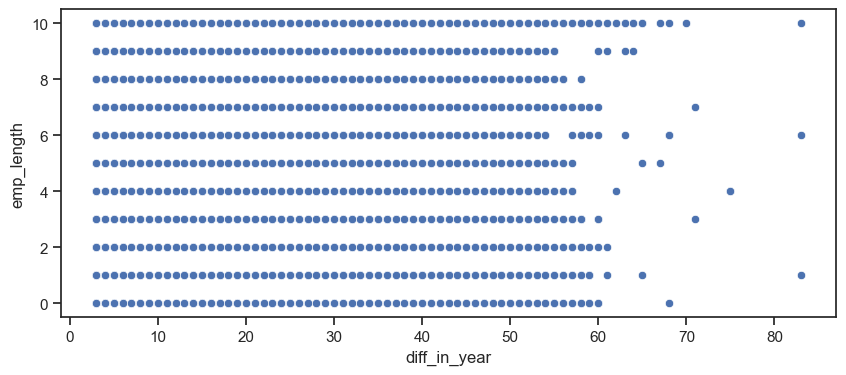

In [222]:
#Посмотрим на распределение этого признака и его связь с признаком emp_length
fig = plt.figure(figsize=(10,4))
sns.scatterplot(data=data, x="diff_in_year", y="emp_length");

>Из полученного графика можно сделать сразу несколько выводов. Во-первых, в данных встречаютя клиенты у которых первый кредит получен > 60 лет назад. То есть на момент получения кредита (даже с учётом того, что первый кредит был студенческим), им должно быть более 75 лет. А это явные выбросы. Во-вторых, стаж и разница в годах между первым и последним кредитом, как это не удивительно, никак не связаны между собой, потому что у клиентов указавших стаж 0 есть первые кредиты, полученные очень давно. Возможно, дело в том, что клиенты указали рабочий стаж в компании,где они работают, а не общий стаж. Очистим данные в признаке `diff_in_year` с помощью метода Тьюки и выставим правую границу с коэфициентом 2. 

In [223]:
#Применим эту функцию к признаку income и определим границы выбросов
lower_bound, upper_bound = outliers_iqr(data, 'diff_in_year', r_ratio=2)
print(f'Верхняя граница поиска выбросов по методу Тьюки: {upper_bound}')
#Очистим данные от выбросов
mask2=data.diff_in_year <= upper_bound
data = data[mask2]
print(f'Количество объектов после отчистки признака от выбросов: {data.shape[0]}')

Верхняя граница поиска выбросов по методу Тьюки: 38.0
Количество объектов после отчистки признака от выбросов: 1543798


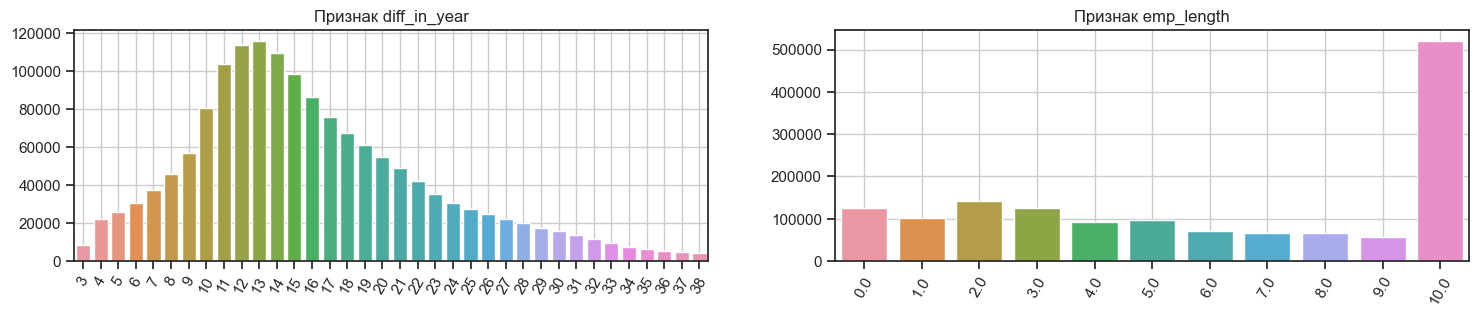

In [224]:
#Посмотрим на 10 самых популярных категорий в показателях
diff_in_year = data['diff_in_year'].value_counts()
emp_length = data['emp_length'].value_counts()

#Построим коробчатые диаграммы по признакам 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
a = sns.barplot(x = diff_in_year.index, y = diff_in_year.values, ax=axes[0]);
axes[0].tick_params(axis='x', rotation=60)
axes[0].set_title('Признак diff_in_year');
axes[0].grid()
b = sns.barplot(x = emp_length.index, y = emp_length.values, ax=axes[1]);
axes[1].tick_params(axis='x', rotation=60)
axes[1].set_title('Признак emp_length');
axes[1].grid()

> На графиках вижно, что в признаке `emp_length` преобладает значение 10 лет и более. Заменим все пропуски на это значение. 

In [225]:
emp_length = data[data['emp_length'].isnull() == True]['emp_length'].index

for i in emp_length:
    data['emp_length'][i] = 10
#Проверим действительно ли мы заменили пропуски
print (f"Количество пропущеных строк в признаке emp_length: {data['emp_length'].isnull().sum()}")

Количество пропущеных строк в признаке emp_length: 0


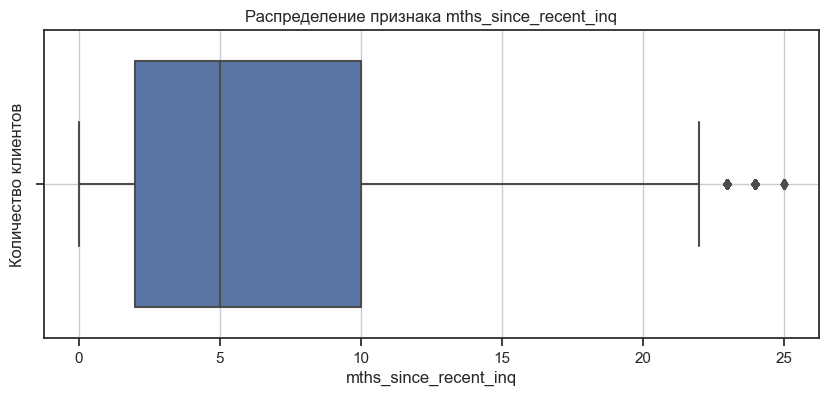

In [226]:
#Построим коробчатую диаграмму для признака mths_since_recent_inq
fig = plt.figure(figsize=(10, 4))
boxplot = sns.boxplot(data, 
    x='mths_since_recent_inq',
    );

boxplot.set_title('Распределение признака mths_since_recent_inq');
boxplot.set_ylabel('Количество клиентов');
boxplot.grid()

> Здесь тоже есть выбросы, но они незначительные. Объеденим все месяцы свыше 24 в одну группу, а пропущеные значения заменим на медианные.

In [227]:
#Преобразуем данные
data['mths_since_recent_inq'] = data['mths_since_recent_inq'].apply(lambda x: 24.0 if x > 24.0 else x)

#Определим к какому штату относится данный клиент
index = data[(data['mths_since_recent_inq'].isnull() == True)]['mths_since_recent_inq'].index
median = data['mths_since_recent_inq'].median()
for i in index:
        data['mths_since_recent_inq'][i] = median
#Проверим действительно ли мы заменили пропуски
print (f"Количество пропущеных строк в признаке mths_since_recent_inq: {data['mths_since_recent_inq'].isnull().sum()}")

Количество пропущеных строк в признаке mths_since_recent_inq: 0


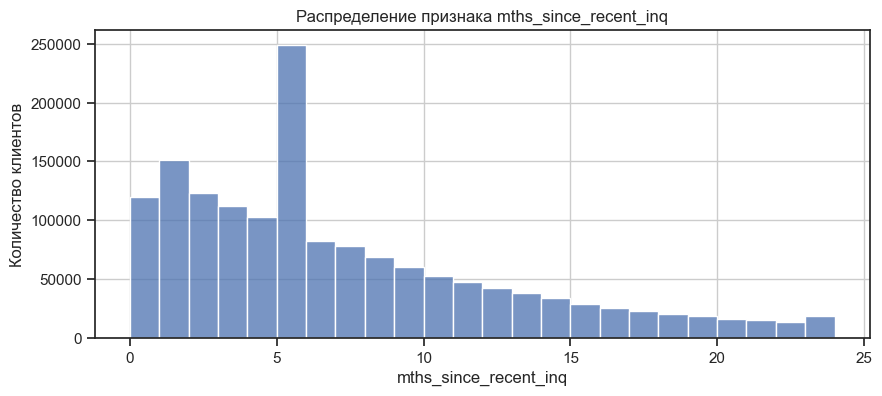

In [228]:
#Построим гистограмму для признака mths_since_recent_inq с новыми данными
fig = plt.figure(figsize=(10, 4))
boxplot = sns.histplot(data, 
    x='mths_since_recent_inq',  
    binwidth=1
    );

boxplot.set_title('Распределение признака mths_since_recent_inq');
boxplot.set_ylabel('Количество клиентов');
boxplot.grid()

In [229]:
#Добавим матрицу корреляции со всеми признаками, добавив к ним признак year_issue_d, с помощью которого мы рассчитывали разницу в годах между кредитами
corr = data[['year_cr_line', 'mnth_cr_line', 'diff_in_year', 'year_issue_d', 'mths_since_recent_inq', 'loan_status']].corr()
corr.style.background_gradient()

,year_cr_line,mnth_cr_line,diff_in_year,year_issue_d,mths_since_recent_inq,loan_status
year_cr_line,1.000000,-0.025281,-0.973573,0.244028,0.000629,-0.052665
mnth_cr_line,-0.025281,1.000000,0.025592,-0.002011,0.001732,0.000309
diff_in_year,-0.973573,0.025592,1.000000,-0.016106,-0.000613,0.045854
year_issue_d,0.244028,-0.002011,-0.016106,1.000000,0.000152,-0.035866
mths_since_recent_inq,0.000629,0.001732,-0.000613,0.000152,1.000000,0.048132
loan_status,-0.052665,0.000309,0.045854,-0.035866,0.048132,1.000000


> Выдно высокую обратную корреляцию между признаками `year_cr_line` и `diff_in_year`. А так же очень низкое влияние на целевой признак `mnth_cr_line`. Удалим признаки `mnth_cr_line` и `year_cr_line`.


In [230]:
data = data.drop (['year_cr_line', 'mnth_cr_line', 'diff_in_year'], axis=1)
data.shape

(1543798, 29)

### Ещё один взгляд на данные

<AxesSubplot: >

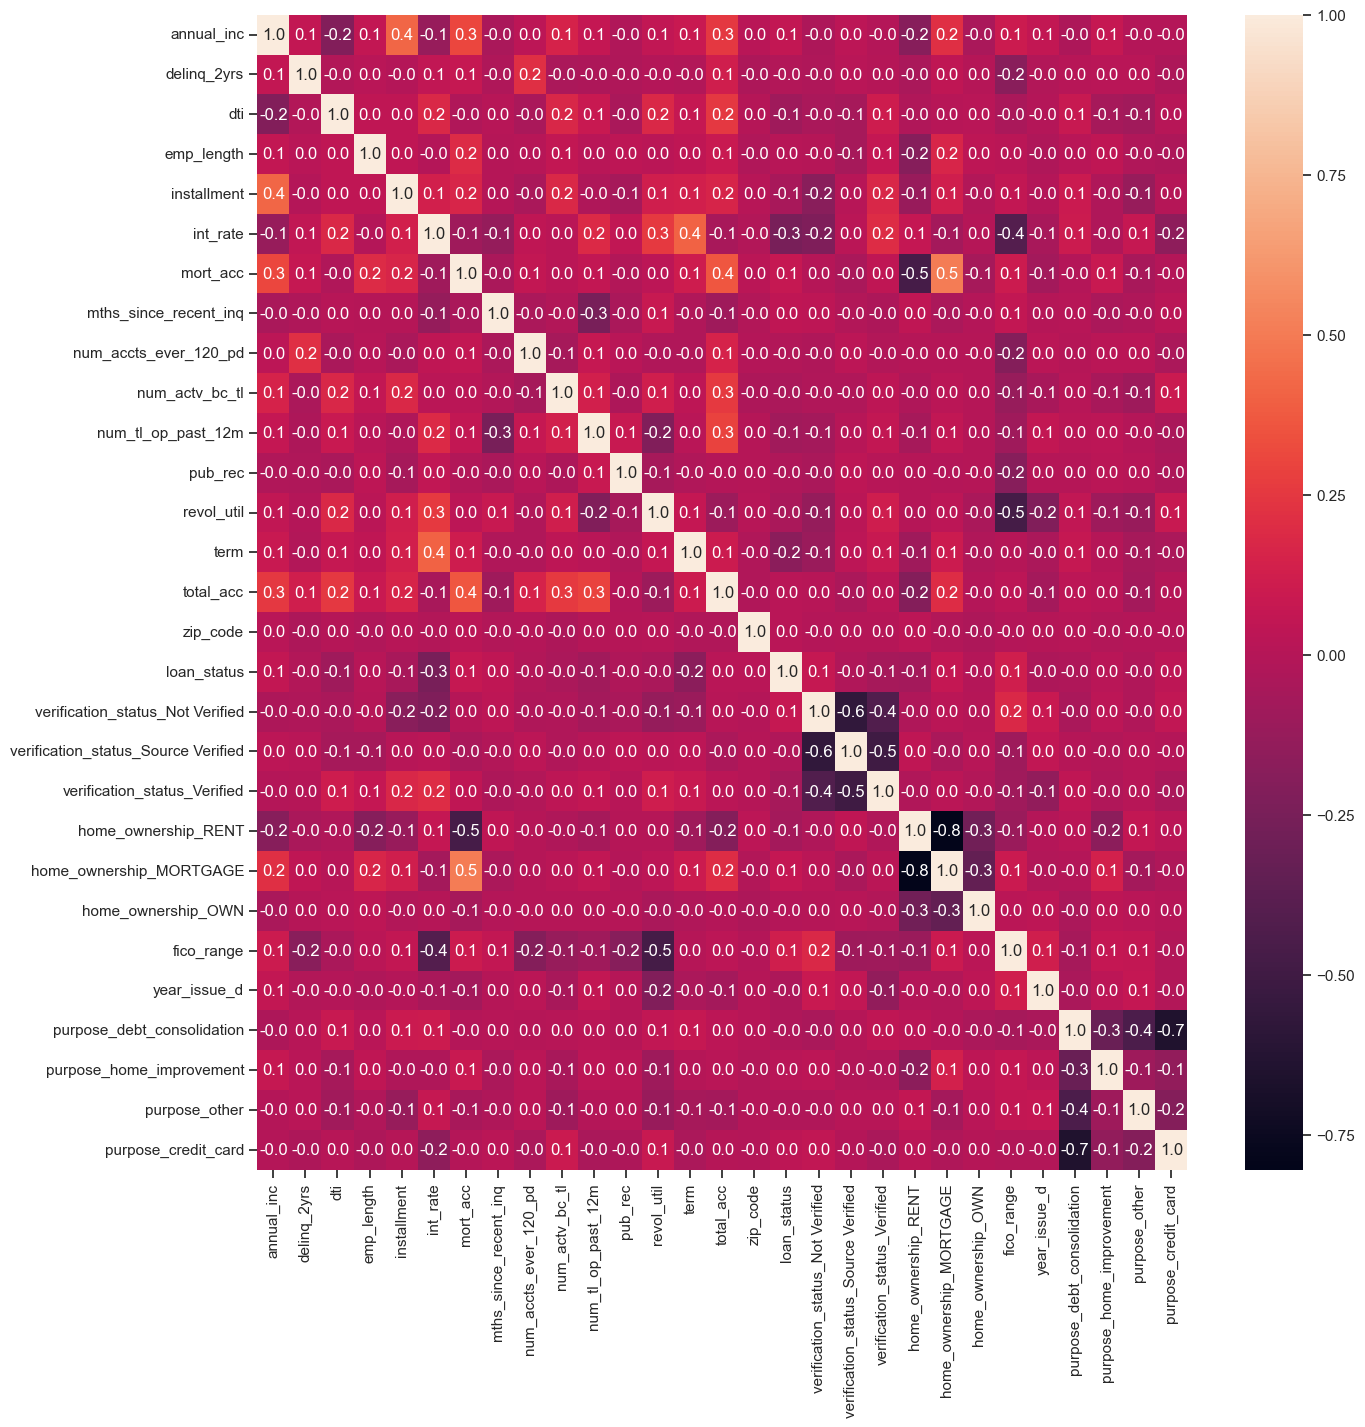

In [231]:
corr = data.corr()
fig = plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, fmt=".1f")

> Конечно, такую матрицу читать не очень удобно, но даже здесь видно мультиколениарность между признаками `home_ownership_RENT` и `home_ownership_MORTGAGE`. Признаками  `purpose_debt_consolidation` и `purpose_credit_card`. А также `verification_status_Source Verified` и `verification_status_Not Verified`. При создании признаков с помощью OneHotEncoding  рекомендуется удалять один из признаков, чтобы избежать таких проблем. Удалим `home_ownership_RENT`, `purpose_debt_consolidation` и `verification_status_Source Verified`.

In [232]:
data = data.drop (['home_ownership_RENT', 'purpose_debt_consolidation', 'verification_status_Source Verified'], axis=1)
data.shape

(1543798, 26)

> В итоге мы получили датасет на 1543798 строк и 25 столбцов, исключая целевой показатель.

## Нормализация данных

In [233]:
columnsH0 = list()
columnsH1 = list()
alpha = 0.05
for i in data.columns:
    _, p = shapiro(data[i])
    #print('p = %.3f' % p)
    # Интерпретируем полученный результат 
    if p > alpha:
        columnsH0.append(i)
    else:
        columnsH1.append(i)

if len (columnsH0) > 0: print(f'В признаках {columnsH0} данные распределены нормально')
if len (columnsH1) > 0: print(f'В признаках {columnsH1} данные не распределены нормально')

В признаках ['annual_inc', 'delinq_2yrs', 'dti', 'emp_length', 'installment', 'int_rate', 'mort_acc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_tl_op_past_12m', 'pub_rec', 'revol_util', 'term', 'total_acc', 'zip_code', 'loan_status', 'verification_status_Not Verified', 'verification_status_Verified', 'home_ownership_MORTGAGE', 'home_ownership_OWN', 'fico_range', 'year_issue_d', 'purpose_home_improvement', 'purpose_other', 'purpose_credit_card'] данные не распределены нормально


> Мы видим, что все признаки не распределены нормально, а это значит, что их необходимо нормализовтаь. Так как мы уже обработали данные от выбросов, то воспользуемся методом MinMaxScaler. Но перед этим отделим целевой признак. 

In [234]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']

In [235]:
# инициализируем нормализатор MinMaxScaler
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
X_mm = mm_scaler.fit_transform(X)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
X_mm = pd.DataFrame(X_mm, columns=X.columns)

X_mm.head()

,annual_inc,delinq_2yrs,dti,emp_length,installment,int_rate,mort_acc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,...,zip_code,verification_status_Not Verified,verification_status_Verified,home_ownership_MORTGAGE,home_ownership_OWN,fico_range,year_issue_d,purpose_home_improvement,purpose_other,purpose_credit_card
0,0.178564,0.000000,0.115279,0.4,0.256766,0.239865,0.000000,0.125000,0.0,0.363636,...,0.276210,1.0,0.0,0.0,0.0,0.323450,0.125,0.0,0.0,0.0
1,0.080378,0.000000,0.062016,0.2,0.050090,0.239865,0.000000,0.125000,0.0,0.181818,...,0.781250,0.0,0.0,1.0,0.0,0.512129,0.125,1.0,0.0,0.0
2,0.154499,0.000000,0.571643,1.0,0.688786,0.239865,0.444444,0.333333,0.0,0.181818,...,0.477823,0.0,1.0,0.0,1.0,0.377358,0.125,0.0,0.0,0.0
3,0.354240,0.000000,0.315079,0.3,0.240218,0.097551,0.111111,0.416667,0.0,0.363636,...,0.781250,1.0,0.0,1.0,0.0,0.242588,0.125,0.0,0.0,0.0
4,0.313329,0.025641,0.250313,0.4,0.325078,0.318412,0.000000,0.208333,0.0,0.272727,...,0.277218,1.0,0.0,0.0,0.0,0.053908,0.125,0.0,0.0,0.0


## Построение модели Дерева решений

In [236]:
#Разобьём данные на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_mm, y, stratify=y, test_size=0.3,  random_state=RANDOM_SEED)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1080658, 25)
Test shape: (463140, 25)


> Для определения эффективности модели воспользуемся двумя основными метриками:

- `ROC-AUC` - позволяющий определить качество бинарной классификации. Считается, что показатель 0,5 равен случайному.  
- `F1-мера` - характеристика, которая позволяет дать оценку точности (сколько из предсказанных объектов класса, действительно принадлежат этому классу) и полноте (сколько от общего числа реальных объектов класса, было предсказано).

Так как банку выше риск, что клиент не вернёт заёмные средства, нас больше интересует распределение по классу 0. Если классификатор в системе кредитного скоринга определит «плохого» заёмщика как «хорошего» и ему будет выдан кредит, то при банкротстве последнего банк потенциально теряет всю сумму кредита. Напротив, если «хороший» заёмщик будет классифицирован как «плохой», банк рискует только упущенной выгодой в виде процентов.

Распределение между классами не сбалансировано. С такими данными лучше работают деревья решений, чем логистическая регрессия. Попробуем построить модель на параметрах по умолчанию, но укажем, что у нас разбалансированны классы. 

In [237]:
#Создаём объект класса DecisionTreeClassifier
DecisionTree = tree.DecisionTreeClassifier(random_state=RANDOM_SEED, class_weight='balanced')
#Обучаем модель по алгоритму CART
DecisionTree.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = DecisionTree.predict(X_train)
y_pred_test = DecisionTree.predict(X_test)

#Рассчитываем метрики
roc_auc_train = metrics.roc_auc_score(y_train, y_pred_train)
print('Метрики на тренировочной выборке: ROC AUC = %.3f' % (roc_auc_train))
print(metrics.f1_score(y_train, y_pred_train, average='macro'))

roc_auc_test = metrics.roc_auc_score(y_test, y_pred_test)
print('Метрики на тестовой выборке: ROC AUC = %.3f' % (roc_auc_test))
print(metrics.classification_report(y_test, y_pred_test))

Метрики на тренировочной выборке: ROC AUC = 1.000
1.0
Метрики на тестовой выборке: ROC AUC = 0.544
              precision    recall  f1-score   support

           0       0.27      0.27      0.27     90240
           1       0.82      0.82      0.82    372900

    accuracy                           0.71    463140
   macro avg       0.54      0.54      0.54    463140
weighted avg       0.71      0.71      0.71    463140



> Как видно, мы получили полностью переобученное дерево, то есть модель подстроилась под тренировочные данные и не смогла отработать на тестовых. Но даже так, нам удалось получить `ROC AUC = 0.544`. Попробуем подобрать наилучшие параметры для модели с помощью `hyperopt`.

In [238]:
# Настроим оптимизацию гиперпараметров для алгоритма случайного леса ориентируясь на предыдущие подобранные параметры
space={'min_samples_leaf': hp.quniform('min_samples_leaf', 50, 500, 50),
       'max_depth': hp.quniform('max_depth', 50, 500, 50),
      }

In [239]:
#Создадим функцию для минимизации метрики, она должна принимать словарь значений гиперпараметров и возвращать значение целевой функции.
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=RANDOM_SEED):
    # функция получает комбинацию гиперпараметров в "params"
    params = {'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
    model = tree.DecisionTreeClassifier(**params, random_state=RANDOM_SEED, class_weight='balanced')
    model.fit(X, y)
    score = metrics.roc_auc_score(y, model.predict(X))
    score = model_selection.cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1).mean()
    return -score

In [240]:
# начинаем подбор гиперпараметров
trials = Trials()
best=fmin(hyperopt_rf, # наша функция 
    space=space,
    max_evals=10,
    trials=trials, 
    rstate=np.random.default_rng(RANDOM_SEED)
)
print("Наилучшие значения гиперпараметров {}".format(best))

TPE is being used as the default algorithm.


100%|██████████| 10/10 [07:11<00:00, 43.11s/trial, best loss: -0.7004143858166889]
Наилучшие значения гиперпараметров {'max_depth': 350.0, 'min_samples_leaf': 400.0}


> Обучем дерево решений на подобранных гиперпараметрах

In [241]:
DecisionTree = tree.DecisionTreeClassifier(random_state=RANDOM_SEED, max_depth=350, min_samples_leaf=400, class_weight='balanced')
DecisionTree.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train = DecisionTree.predict(X_train)
y_pred_test = DecisionTree.predict(X_test)

#Рассчитываем метрики
roc_auc_train = metrics.roc_auc_score(y_train, y_pred_train)
print('Метрики на тренировочной выборке: ROC AUC = %.3f' % (roc_auc_train))
print(metrics.classification_report(y_train, y_pred_train))

roc_auc_test = metrics.roc_auc_score(y_test, y_pred_test)
print('Метрики на тестовой выборке: ROC AUC = %.3f' % (roc_auc_test))
print(metrics.classification_report(y_test, y_pred_test))

Метрики на тренировочной выборке: ROC AUC = 0.662
              precision    recall  f1-score   support

           0       0.31      0.69      0.43    210559
           1       0.89      0.64      0.74    870099

    accuracy                           0.65   1080658
   macro avg       0.60      0.66      0.59   1080658
weighted avg       0.78      0.65      0.68   1080658

Метрики на тестовой выборке: ROC AUC = 0.645
              precision    recall  f1-score   support

           0       0.30      0.66      0.41     90240
           1       0.88      0.63      0.74    372900

    accuracy                           0.64    463140
   macro avg       0.59      0.64      0.57    463140
weighted avg       0.77      0.64      0.67    463140



> Как мы видим, с помощью оптимальных гиперпараметров нам удалось улучшить результат модели по метрике `ROC AUC` на 0.1. А метрику `F1` по классу 0 удалось повысить на 0.14. Этот показатель намного лучше. 

## Построение модели RandomForest

> Построим модель Случайного леса, ограничив максимальную глубину и минимальное количество листьев параметрами, подобранными в дереве решений.

In [242]:
RandomForest = ensemble.RandomForestClassifier(random_state=RANDOM_SEED, max_depth=350, min_samples_leaf=400, class_weight='balanced')
RandomForest.fit(X_train, y_train)

#Делаем предсказание класса
y_pred_train_rf = RandomForest.predict(X_train)
y_pred_test_rf = RandomForest.predict(X_test)

#Рассчитываем метрики
roc_auc_train = metrics.roc_auc_score(y_train, y_pred_train_rf)
print('Метрики на тренировочной выборке: ROC AUC = %.3f' % (roc_auc_train))
print(metrics.classification_report(y_train, y_pred_train_rf))

roc_auc_test = metrics.roc_auc_score(y_test, y_pred_test_rf)
print('Метрики на тестовой выборке: ROC AUC = %.3f' % (roc_auc_test))
print(metrics.classification_report(y_test, y_pred_test_rf))

Метрики на тренировочной выборке: ROC AUC = 0.662
              precision    recall  f1-score   support

           0       0.31      0.68      0.43    210559
           1       0.89      0.64      0.75    870099

    accuracy                           0.65   1080658
   macro avg       0.60      0.66      0.59   1080658
weighted avg       0.78      0.65      0.68   1080658

Метрики на тестовой выборке: ROC AUC = 0.654
              precision    recall  f1-score   support

           0       0.31      0.67      0.42     90240
           1       0.89      0.64      0.74    372900

    accuracy                           0.64    463140
   macro avg       0.60      0.65      0.58    463140
weighted avg       0.78      0.64      0.68    463140



> Как мы видим, нам удалось получить незначительное улучшение метрик по сравнению с деревьями решений. Но самая большая проблема с несбалансированными классами так и не решилась. Метрика F1 для класса 0 всё ещё ниже, чем для класса 1.

## Сэмплирование данных

>Попробуем решить проблему с неравномерным распределением классов с помощью сэмплирования. Так как у нас большой датасет мы воспользуемся методом недо-семплирования и уменьшим наш датасет в данных, принадлежащих классу 1.

In [243]:
from imblearn.under_sampling import NearMiss

nm1 = NearMiss()
X_resampled, y_resampled = nm1.fit_resample(X_mm, y)

print('Набор данных до обработки:', X_mm.shape) 
print('Разпределение классов до обработки: \n', y.value_counts(), sep='')
print('-'*40)
print('Набор данных после сэмплирования:', X_resampled.shape)
print('Разпределение классов после сэмплирования: \n', y_resampled.value_counts(), sep='')

Набор данных до обработки: (1543798, 25)
Разпределение классов до обработки: 
1    1242999
0     300799
Name: loan_status, dtype: int64
----------------------------------------
Набор данных после сэмплирования: (601598, 25)
Разпределение классов после сэмплирования: 
0    300799
1    300799
Name: loan_status, dtype: int64


> Мы значительно уменьшили наш датасет, зато получили новый, в котором данные распределены по классам в пропорции 50/50. Посмотрим, поможет ли это нам лучше предсказывать значения класса 0.

In [244]:
#Разобьём новые данные на тестовую и обучающую выборки
X_train_rs, X_test_rs, y_train_rs, y_test_rs = model_selection.train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=RANDOM_SEED)
print('Train shape: {}'.format(X_train_rs.shape))
print('Test shape: {}'.format(X_test_rs.shape))

Train shape: (421118, 25)
Test shape: (180480, 25)


In [245]:
#Построим модель случайного леса по заранее подобранным параметрам и посчитаем метрики на тестовых данных
RandomForest_rs = ensemble.RandomForestClassifier(random_state=RANDOM_SEED, max_depth=350, min_samples_leaf=400)
RandomForest_rs.fit(X_train_rs, y_train_rs)

y_pred_test_rs = RandomForest_rs.predict(X_test_rs)

#Рассчитываем метрики
roc_auc_test = metrics.roc_auc_score(y_test_rs, y_pred_test_rs)
print('Метрики на тестовой выборке: ROC AUC = %.3f' % (roc_auc_test))
print(metrics.classification_report(y_test_rs, y_pred_test_rs))

Метрики на тестовой выборке: ROC AUC = 0.745
              precision    recall  f1-score   support

           0       0.75      0.74      0.74     90141
           1       0.74      0.75      0.75     90339

    accuracy                           0.74    180480
   macro avg       0.74      0.74      0.74    180480
weighted avg       0.74      0.74      0.74    180480



> Мы видим что метрики значительно улучшились по сравнению с обычными данными. Это отличный результат нам удалось выстроить модель, которая предсказывает значения с высокой точностью. Проверим, так ли это. 

In [246]:
#Предскажем классы по тестовой выборке до сэмплирования
y_pred_test_rs_all = RandomForest_rs.predict(X_test)

roc_auc_test = metrics.roc_auc_score(y_test, y_pred_test_rs_all)
print('Метрики на тестовой выборке до сэмплирования: ROC AUC = %.3f' % (roc_auc_test))
print(metrics.classification_report(y_test, y_pred_test_rs_all))

Метрики на тестовой выборке до сэмплирования: ROC AUC = 0.547
              precision    recall  f1-score   support

           0       0.22      0.74      0.34     90240
           1       0.85      0.36      0.50    372900

    accuracy                           0.43    463140
   macro avg       0.53      0.55      0.42    463140
weighted avg       0.73      0.43      0.47    463140



> К сожалению, столкнувшись с реальными данными, модель вновь показывает не самый высокий результат. Даже ниже, чем до сэмплирования. Так что такая модель не работоспособна.

### Выводы

Приступая к работе над датасетом я не ожидала, насколько увлекательным окажется это путешествие. Я обработала больше 30 признаков. К каждому из них построила как минимум по 1 графику, в большинстве из них проанализировала наличие выбросов и влияние на целевой признак. Итоговый датасет уменьшился более чем на 340 тысяч строк, а его структура претерпела значительные изменения. 

Я провела тест на нормальность, а затем нормализовала данные, после чего построила несколько моделей. Не все они оказались успешными, но мне удалось улучшить гиперпараметры модели и получить модель со значением метрики `ROC AUC` = 0.654 и `F1` от класса 0 = 0.42. К сожалению, сэмплирование данных хоть и показало хорошие результаты, но модель оказалась неработоспособной на реальных данных. Скорее всего, мне просто не хватило каких-то дополнительных данных, которые помогли бы деревьям решений более чётко определять расположенность классов. Но это уже задача для другого исследования.